# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
# from fbprophet import Prophet

In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


Because our client is only interested in safe investments, we are only going to consider the largest zipcodes in the 3 largest cities. New York (Manhattan), Chicago, and LA. 

In [4]:
ny = df[df['City'] == 'New York']
ny.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
10,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
12,62087,11375,New York,NY,New York,Queens,13,252400.0,251800.0,251400.0,...,1022600,1033700,1048600,1066400,1081200,1088800,1092700,1089500,1084000,1084600
13,62045,11235,New York,NY,New York,Kings,14,190500.0,191000.0,191500.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
20,61625,10011,New York,NY,New York,New York,21,NaN,NaN,NaN,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300


In [5]:
ny['CountyName'].unique()

array(['Bronx', 'Kings', 'Queens', 'New York', 'Richmond'], dtype=object)

In [6]:
ny = ny[ny['CountyName'] == 'New York']

In [7]:
ny.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,6.00000,6.000000,6.000000,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00
mean,61773.50000,10418.500000,647.833333,1.920650e+06,1.934750e+06,1.947750e+06,1.960650e+06,1.974600e+06,1.990900e+06,2.009400e+06,...,8.717583e+06,8.689867e+06,8.640767e+06,8.607333e+06,8.552433e+06,8.515767e+06,8.542433e+06,8.526100e+06,8.413050e+06,8.311317e+06
std,197.17581,583.932445,766.391393,2.483430e+06,2.502380e+06,2.519916e+06,2.537028e+06,2.555767e+06,2.577546e+06,2.602436e+06,...,6.506946e+06,6.440418e+06,6.394274e+06,6.375367e+06,6.322329e+06,6.271338e+06,6.287585e+06,6.316838e+06,6.211166e+06,6.046987e+06
min,61625.00000,10011.000000,21.000000,1.646000e+05,1.653000e+05,1.659000e+05,1.667000e+05,1.674000e+05,1.683000e+05,1.692000e+05,...,9.874000e+05,9.956000e+05,9.976000e+05,1.000800e+06,1.017900e+06,1.043900e+06,1.067100e+06,1.079200e+06,1.091000e+06,1.104300e+06
25%,61629.75000,10015.750000,84.750000,1.042625e+06,1.050025e+06,1.056825e+06,1.063675e+06,1.071000e+06,1.079600e+06,1.089300e+06,...,4.047475e+06,4.065325e+06,4.073500e+06,4.080875e+06,4.066150e+06,4.056875e+06,4.062300e+06,4.068075e+06,4.093750e+06,4.130025e+06
50%,61669.00000,10074.500000,391.000000,1.920650e+06,1.934750e+06,1.947750e+06,1.960650e+06,1.974600e+06,1.990900e+06,2.009400e+06,...,8.682000e+06,8.690600e+06,8.623150e+06,8.529150e+06,8.443600e+06,8.417750e+06,8.439100e+06,8.361850e+06,8.241300e+06,8.172950e+06
75%,61932.50000,10861.500000,926.750000,2.798675e+06,2.819475e+06,2.838675e+06,2.857625e+06,2.878200e+06,2.902200e+06,2.929500e+06,...,1.159168e+07,1.157415e+07,1.148462e+07,1.144532e+07,1.139118e+07,1.133308e+07,1.136480e+07,1.123032e+07,1.095215e+07,1.084855e+07
max,62041.00000,11231.000000,1996.000000,3.676700e+06,3.704200e+06,3.729600e+06,3.754600e+06,3.781800e+06,3.813500e+06,3.849600e+06,...,1.888990e+07,1.870350e+07,1.860530e+07,1.856940e+07,1.842880e+07,1.830710e+07,1.836590e+07,1.853040e+07,1.833770e+07,1.789490e+07


In [8]:
ny.dropna(inplace=True)
ny.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,2.000000,2.000000,2.00000,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
mean,61856.000000,10617.000000,544.00000,1.920650e+06,1.934750e+06,1.947750e+06,1.960650e+06,1.974600e+06,1.990900e+06,2.009400e+06,...,4.198750e+06,4.209000e+06,4.207600e+06,4.214050e+06,4.194650e+06,4.193300e+06,4.210200e+06,4.214750e+06,4.227000e+06,4.245450e+06
std,216.374675,691.550432,738.21948,2.483430e+06,2.502380e+06,2.519916e+06,2.537028e+06,2.555767e+06,2.577546e+06,2.602436e+06,...,4.541535e+06,4.544434e+06,4.539626e+06,4.544222e+06,4.492603e+06,4.453924e+06,4.445015e+06,4.434337e+06,4.434974e+06,4.442257e+06
min,61703.000000,10128.000000,22.00000,1.646000e+05,1.653000e+05,1.659000e+05,1.667000e+05,1.674000e+05,1.683000e+05,1.692000e+05,...,9.874000e+05,9.956000e+05,9.976000e+05,1.000800e+06,1.017900e+06,1.043900e+06,1.067100e+06,1.079200e+06,1.091000e+06,1.104300e+06
25%,61779.500000,10372.500000,283.00000,1.042625e+06,1.050025e+06,1.056825e+06,1.063675e+06,1.071000e+06,1.079600e+06,1.089300e+06,...,2.593075e+06,2.602300e+06,2.602600e+06,2.607425e+06,2.606275e+06,2.618600e+06,2.638650e+06,2.646975e+06,2.659000e+06,2.674875e+06
50%,61856.000000,10617.000000,544.00000,1.920650e+06,1.934750e+06,1.947750e+06,1.960650e+06,1.974600e+06,1.990900e+06,2.009400e+06,...,4.198750e+06,4.209000e+06,4.207600e+06,4.214050e+06,4.194650e+06,4.193300e+06,4.210200e+06,4.214750e+06,4.227000e+06,4.245450e+06
75%,61932.500000,10861.500000,805.00000,2.798675e+06,2.819475e+06,2.838675e+06,2.857625e+06,2.878200e+06,2.902200e+06,2.929500e+06,...,5.804425e+06,5.815700e+06,5.812600e+06,5.820675e+06,5.783025e+06,5.768000e+06,5.781750e+06,5.782525e+06,5.795000e+06,5.816025e+06
max,62009.000000,11106.000000,1066.00000,3.676700e+06,3.704200e+06,3.729600e+06,3.754600e+06,3.781800e+06,3.813500e+06,3.849600e+06,...,7.410100e+06,7.422400e+06,7.417600e+06,7.427300e+06,7.371400e+06,7.342700e+06,7.353300e+06,7.350300e+06,7.363000e+06,7.386600e+06


In [9]:
la = df[df['City'] == 'Los Angeles']
la.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
30,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,31,340600.0,341700.0,343000.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
75,96015,90034,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,76,231300.0,231700.0,232100.0,...,1287500,1310000,1329900,1347200,1360300,1368500,1382700,1398000,1411400,1419100
86,96025,90044,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,87,119500.0,119500.0,119400.0,...,383800,386900,390600,394300,398600,404200,409700,414300,418500,421100
107,96007,90026,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,108,138100.0,138300.0,138300.0,...,883600,895800,907700,919900,932600,947300,962600,973700,975200,972100
133,96047,90066,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,134,241100.0,241000.0,240900.0,...,1435000,1454100,1471100,1473300,1470400,1476200,1490500,1496300,1494000,1489900


In [10]:
la.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,95.000000,95.000000,95.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,...,9.500000e+01,9.500000e+01,9.500000e+01,9.500000e+01,9.500000e+01,9.500000e+01,9.500000e+01,9.500000e+01,9.500000e+01,9.500000e+01
mean,96164.610526,90571.357895,2571.378947,223764.516129,223833.333333,223873.118280,223898.924731,223966.666667,224124.731183,224461.290323,...,9.619884e+05,9.712505e+05,9.817147e+05,9.905758e+05,9.974526e+05,1.004704e+06,1.012981e+06,1.020997e+06,1.028654e+06,1.032797e+06
std,177.419943,642.576064,2083.357214,146385.283506,146786.009087,147188.706251,147598.466393,148042.087386,148562.904007,149225.851613,...,6.730689e+05,6.794576e+05,6.872415e+05,6.931430e+05,6.960244e+05,6.983237e+05,7.030676e+05,7.084077e+05,7.134106e+05,7.157358e+05
min,95983.000000,90002.000000,31.000000,110600.000000,110600.000000,110600.000000,110500.000000,110200.000000,110000.000000,109900.000000,...,3.288000e+05,3.331000e+05,3.370000e+05,3.415000e+05,3.463000e+05,3.509000e+05,3.531000e+05,3.547000e+05,3.567000e+05,3.584000e+05
25%,96011.000000,90030.000000,1008.000000,135700.000000,135300.000000,134900.000000,134400.000000,133900.000000,133600.000000,133600.000000,...,5.406500e+05,5.482000e+05,5.561000e+05,5.616500e+05,5.701500e+05,5.796000e+05,5.846500e+05,5.902000e+05,5.964500e+05,5.944000e+05
50%,96046.000000,90065.000000,2058.000000,165500.000000,166300.000000,166900.000000,166500.000000,166200.000000,165900.000000,165700.000000,...,6.945000e+05,7.021000e+05,7.080000e+05,7.149000e+05,7.234000e+05,7.305000e+05,7.356000e+05,7.399000e+05,7.436000e+05,7.625000e+05
75%,96358.500000,91328.500000,3510.000000,249100.000000,250600.000000,252200.000000,253800.000000,255300.000000,255200.000000,255400.000000,...,1.206050e+06,1.216950e+06,1.226150e+06,1.234550e+06,1.242900e+06,1.250900e+06,1.256550e+06,1.264400e+06,1.275400e+06,1.281700e+06
max,96452.000000,91607.000000,8760.000000,762500.000000,764100.000000,765700.000000,767300.000000,769100.000000,771200.000000,774000.000000,...,3.533200e+06,3.575300e+06,3.621800e+06,3.661400e+06,3.698100e+06,3.730900e+06,3.760500e+06,3.785500e+06,3.819900e+06,3.842700e+06


In [11]:
la.dropna(inplace=True)
la.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,...,9.300000e+01,9.300000e+01,9.300000e+01,9.300000e+01,9.300000e+01,9.300000e+01,9.300000e+01,9.300000e+01,9.300000e+01,9.300000e+01
mean,96168.268817,90583.354839,2470.129032,223764.516129,223833.333333,223873.118280,223898.924731,223966.666667,224124.731183,224461.290323,...,9.693613e+05,9.787656e+05,9.893602e+05,9.982849e+05,1.005139e+06,1.012359e+06,1.020692e+06,1.028884e+06,1.036853e+06,1.041249e+06
std,177.537390,644.181139,1982.905889,146385.283506,146786.009087,147188.706251,147598.466393,148042.087386,148562.904007,149225.851613,...,6.784174e+05,6.848193e+05,6.926402e+05,6.985832e+05,7.015043e+05,7.038449e+05,7.086297e+05,7.139536e+05,7.188522e+05,7.210614e+05
min,95983.000000,90002.000000,31.000000,110600.000000,110600.000000,110600.000000,110500.000000,110200.000000,110000.000000,109900.000000,...,3.288000e+05,3.331000e+05,3.370000e+05,3.415000e+05,3.463000e+05,3.509000e+05,3.531000e+05,3.547000e+05,3.567000e+05,3.584000e+05
25%,96013.000000,90032.000000,986.000000,135700.000000,135300.000000,134900.000000,134400.000000,133900.000000,133600.000000,133600.000000,...,5.405000e+05,5.455000e+05,5.506000e+05,5.574000e+05,5.696000e+05,5.763000e+05,5.815000e+05,5.881000e+05,5.941000e+05,5.970000e+05
50%,96047.000000,90066.000000,2002.000000,165500.000000,166300.000000,166900.000000,166500.000000,166200.000000,165900.000000,165700.000000,...,7.085000e+05,7.122000e+05,7.169000e+05,7.213000e+05,7.255000e+05,7.319000e+05,7.367000e+05,7.501000e+05,7.604000e+05,7.638000e+05
75%,96361.000000,91331.000000,3361.000000,249100.000000,250600.000000,252200.000000,253800.000000,255300.000000,255200.000000,255400.000000,...,1.209200e+06,1.219200e+06,1.230900e+06,1.244300e+06,1.254900e+06,1.263700e+06,1.270500e+06,1.280300e+06,1.291300e+06,1.296900e+06
max,96452.000000,91607.000000,8760.000000,762500.000000,764100.000000,765700.000000,767300.000000,769100.000000,771200.000000,774000.000000,...,3.533200e+06,3.575300e+06,3.621800e+06,3.661400e+06,3.698100e+06,3.730900e+06,3.760500e+06,3.785500e+06,3.819900e+06,3.842700e+06


In [12]:
chicago = df[df['City'] == 'Chicago']
chicago.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0,143100.0,143400.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


In [13]:
chicago.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,41.000000,41.000000,41.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,4.100000e+01,4.100000e+01,4.100000e+01,4.100000e+01,4.100000e+01,4.100000e+01,4.100000e+01,4.100000e+01,4.100000e+01,4.100000e+01
mean,92317.829268,60633.097561,1266.536585,176757.500000,177220.000000,177500.000000,177560.000000,177435.000000,177100.000000,176600.000000,...,4.694220e+05,4.699415e+05,4.702098e+05,4.713268e+05,4.729415e+05,4.741537e+05,4.760268e+05,4.779098e+05,4.784756e+05,4.772927e+05
std,49207.238957,16.887577,1660.637153,108042.695472,108234.747726,108404.588795,108515.469298,108595.966186,108633.958425,108629.561071,...,3.619827e+05,3.621618e+05,3.619668e+05,3.629022e+05,3.642891e+05,3.659291e+05,3.682427e+05,3.702165e+05,3.705056e+05,3.689474e+05
min,84607.000000,60605.000000,1.000000,71900.000000,72500.000000,73000.000000,73300.000000,73400.000000,73300.000000,73000.000000,...,1.033000e+05,1.047000e+05,1.054000e+05,1.068000e+05,1.090000e+05,1.104000e+05,1.115000e+05,1.128000e+05,1.133000e+05,1.130000e+05
25%,84620.000000,60618.000000,106.000000,103000.000000,103650.000000,104000.000000,104100.000000,103975.000000,103550.000000,103325.000000,...,2.224000e+05,2.231000e+05,2.229000e+05,2.233000e+05,2.246000e+05,2.261000e+05,2.287000e+05,2.314000e+05,2.327000e+05,2.326000e+05
50%,84634.000000,60633.000000,498.000000,149750.000000,149700.000000,149450.000000,149100.000000,149050.000000,148650.000000,148000.000000,...,3.555000e+05,3.562000e+05,3.571000e+05,3.580000e+05,3.585000e+05,3.552000e+05,3.539000e+05,3.564000e+05,3.569000e+05,3.562000e+05
75%,84647.000000,60647.000000,1991.000000,201875.000000,202950.000000,203700.000000,204075.000000,204050.000000,203750.000000,204125.000000,...,5.757000e+05,5.746000e+05,5.738000e+05,5.744000e+05,5.764000e+05,5.785000e+05,5.795000e+05,5.797000e+05,5.792000e+05,5.776000e+05
max,399713.000000,60660.000000,7864.000000,510000.000000,510200.000000,510100.000000,509600.000000,508800.000000,507300.000000,505300.000000,...,1.475200e+06,1.473900e+06,1.469500e+06,1.472100e+06,1.477800e+06,1.486000e+06,1.497300e+06,1.508600e+06,1.508100e+06,1.493200e+06


In [14]:
chicago.dropna(inplace=True)
chicago.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01
mean,92510.450000,60633.650000,1295.550000,176757.500000,177220.000000,177500.000000,177560.000000,177435.000000,177100.000000,176600.000000,...,4.442775e+05,4.448425e+05,4.452275e+05,4.463075e+05,4.478200e+05,4.488575e+05,4.504950e+05,4.521425e+05,4.527350e+05,4.518950e+05
std,49818.451459,16.723314,1671.235639,108042.695472,108234.747726,108404.588795,108515.469298,108595.966186,108633.958425,108629.561071,...,3.283362e+05,3.286848e+05,3.288384e+05,3.297760e+05,3.310154e+05,3.323088e+05,3.341669e+05,3.356406e+05,3.360535e+05,3.353918e+05
min,84607.000000,60605.000000,1.000000,71900.000000,72500.000000,73000.000000,73300.000000,73400.000000,73300.000000,73000.000000,...,1.033000e+05,1.047000e+05,1.054000e+05,1.068000e+05,1.090000e+05,1.104000e+05,1.115000e+05,1.128000e+05,1.133000e+05,1.130000e+05
25%,84620.750000,60618.750000,133.250000,103000.000000,103650.000000,104000.000000,104100.000000,103975.000000,103550.000000,103325.000000,...,2.173500e+05,2.179750e+05,2.181000e+05,2.188750e+05,2.203750e+05,2.218250e+05,2.240750e+05,2.265500e+05,2.279000e+05,2.279500e+05
50%,84634.500000,60633.500000,568.500000,149750.000000,149700.000000,149450.000000,149100.000000,149050.000000,148650.000000,148000.000000,...,3.554000e+05,3.546000e+05,3.541000e+05,3.540000e+05,3.542500e+05,3.528000e+05,3.536500e+05,3.543500e+05,3.555000e+05,3.558500e+05
75%,84647.250000,60647.500000,2083.500000,201875.000000,202950.000000,203700.000000,204075.000000,204050.000000,203750.000000,204125.000000,...,5.298750e+05,5.305750e+05,5.297750e+05,5.288000e+05,5.299750e+05,5.329000e+05,5.360000e+05,5.380000e+05,5.395250e+05,5.391250e+05
max,399713.000000,60660.000000,7864.000000,510000.000000,510200.000000,510100.000000,509600.000000,508800.000000,507300.000000,505300.000000,...,1.412200e+06,1.420700e+06,1.426200e+06,1.431000e+06,1.436300e+06,1.442400e+06,1.452900e+06,1.464600e+06,1.472400e+06,1.474500e+06


In [15]:
chicago1 = chicago.sort_values(by='SizeRank', ascending=True)[:2]
la1 = la.sort_values(by='SizeRank', ascending=True)[:2]

Aggregate dataframe of the zipcodes we are interested in.

In [16]:
df1 = pd.concat([chicago1, la1, ny])
df1.reset_index(inplace=True)
df1.drop('index', axis=1, inplace=True)
df1

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
2,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,31,340600.0,341700.0,343000.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
3,96015,90034,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,76,231300.0,231700.0,232100.0,...,1287500,1310000,1329900,1347200,1360300,1368500,1382700,1398000,1411400,1419100
4,61703,10128,New York,NY,New York,New York,22,3676700.0,3704200.0,3729600.0,...,7410100,7422400,7417600,7427300,7371400,7342700,7353300,7350300,7363000,7386600
5,62009,11106,New York,NY,New York,New York,1066,164600.0,165300.0,165900.0,...,987400,995600,997600,1000800,1017900,1043900,1067100,1079200,1091000,1104300


Reformatting the dataframe to fit in get_datetimes function without losing zipcodes.

In [17]:
df1.set_index('RegionName', inplace=True)

In [18]:
drop = ['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
dates = df1.drop(drop, axis=1)

# Step 2: Data Preprocessing

In [19]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    return pd.to_datetime(df.columns.values, format='%Y-%m')

In [20]:
columns_new = get_datetimes(dates)
dates.columns = columns_new

The dates are now all datetime so that the model can process them.

In [21]:
dates

,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,1996-11-01,1996-12-01,1997-01-01,...,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01
RegionName,,,,,,,,,,,,,,,,,,,,,
60657,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
60614,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
90046,340600.0,341700.0,343000.0,344400.0,346100.0,348000.0,350300.0,353000.0,356400.0,360400.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
90034,231300.0,231700.0,232100.0,232400.0,232700.0,233200.0,233800.0,234700.0,236000.0,237800.0,...,1287500,1310000,1329900,1347200,1360300,1368500,1382700,1398000,1411400,1419100
10128,3676700.0,3704200.0,3729600.0,3754600.0,3781800.0,3813500.0,3849600.0,3888900.0,3928800.0,3964600.0,...,7410100,7422400,7417600,7427300,7371400,7342700,7353300,7350300,7363000,7386600
11106,164600.0,165300.0,165900.0,166700.0,167400.0,168300.0,169200.0,170300.0,171700.0,173000.0,...,987400,995600,997600,1000800,1017900,1043900,1067100,1079200,1091000,1104300


In [22]:
dates.rename_axis(None, inplace=True)

# Step 3: EDA and Visualization

In [23]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

Transpose the dataframe so that the rows are dates and zipcodes are columns.

In [24]:
transposed = dates.T
transposed.head()
transposed.rename_axis('Dates', inplace=True)

Now we will take a look at the datasets to determine if there are any trends. If there are, we will have to remove the trends before plugging our data into the ARIMA models.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


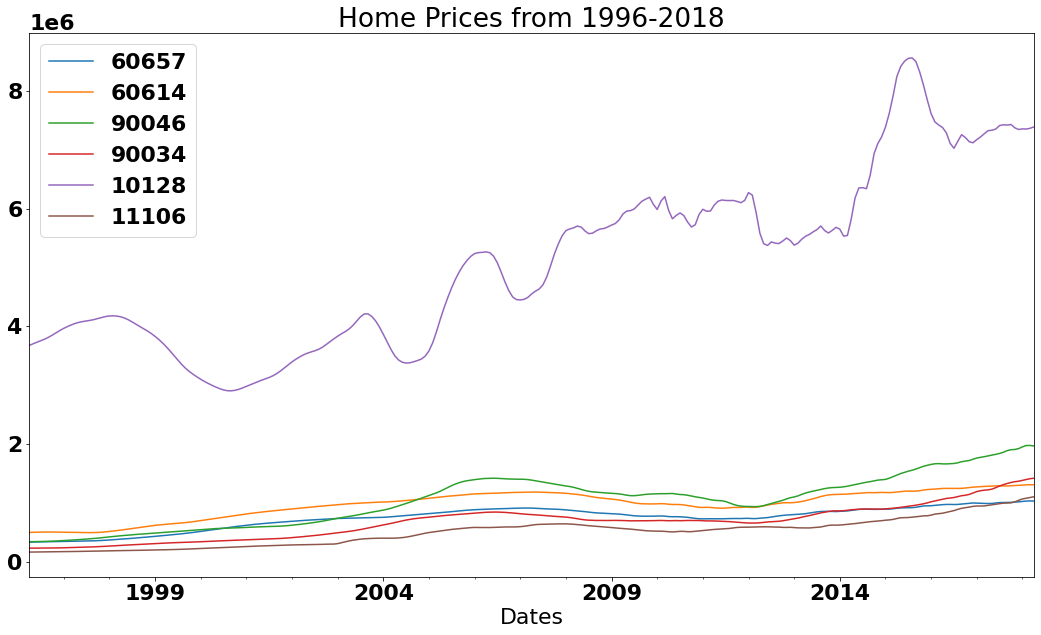

In [25]:
transposed.plot(figsize = (18,10), subplots=False, legend=True)
plt.title('Home Prices from 1996-2018')
plt.show()

The graph shows that there is a positive trend for all of the zipcodes.

In [26]:
#function that prints a rolling mean/std chart and dickey-fuller test
#use to check for trends
def trend(data, column):
    #plotting rolling mean and rolling std
    roll_mean = data[column].rolling(window=12, center=False).mean()
    roll_std = data[column].rolling(window=12, center=False).std()
    fig = plt.figure(figsize=(12,6))
    plt.plot(data[column], color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('{} Rolling Mean & Standard Deviation'.format(column))
    plt.show()
    
    #dickey-fuller test
    print ('Results of Dickey-Fuller Test: \n')
    dftest = adfuller(data[column])

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

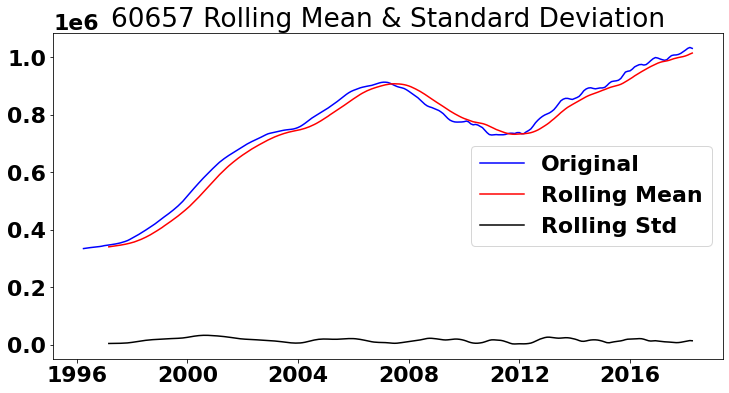

Results of Dickey-Fuller Test: 

Test Statistic                  -2.298046
p-value                          0.172599
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


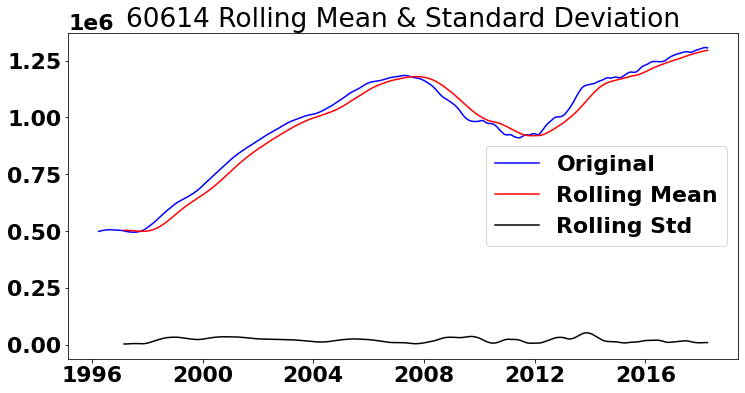

Results of Dickey-Fuller Test: 

Test Statistic                  -2.673573
p-value                          0.078724
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


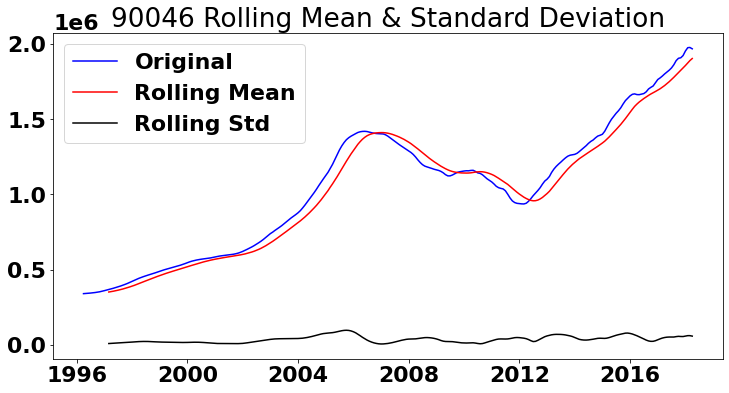

Results of Dickey-Fuller Test: 

Test Statistic                  -0.975326
p-value                          0.762157
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


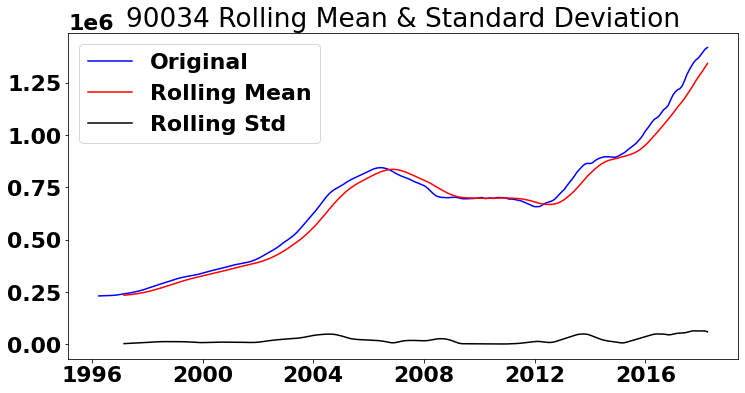

Results of Dickey-Fuller Test: 

Test Statistic                  -0.097219
p-value                          0.949715
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


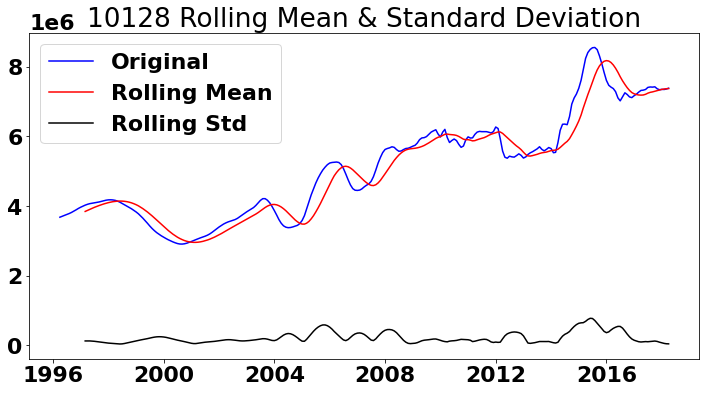

Results of Dickey-Fuller Test: 

Test Statistic                  -0.272859
p-value                          0.929261
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


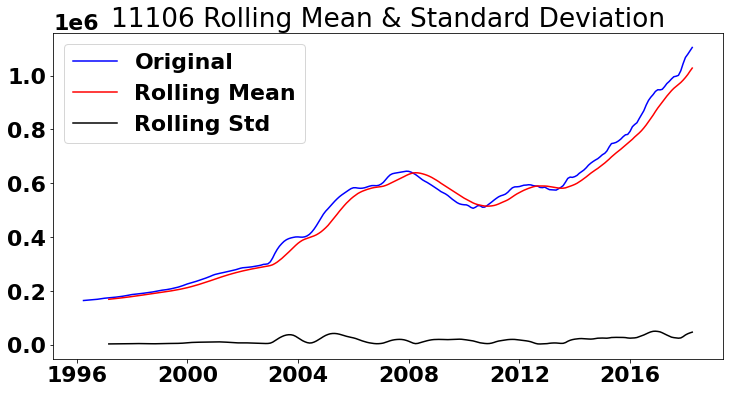

Results of Dickey-Fuller Test: 

Test Statistic                   0.555975
p-value                          0.986479
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [27]:
for column in transposed.columns:
    trend(transposed, column)

As expected, none of the zipcodes pass the dickey-fuller test. I will now try some detrending methods.

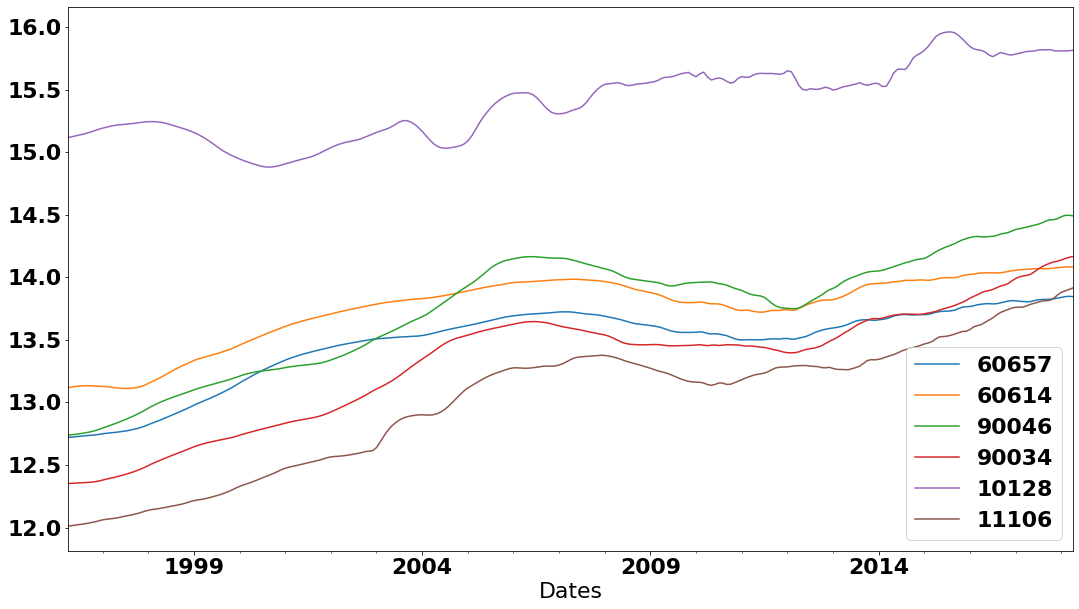

In [28]:
log = np.log(transposed)
log.plot(figsize = (18,10), subplots=False, legend=True)
plt.show()

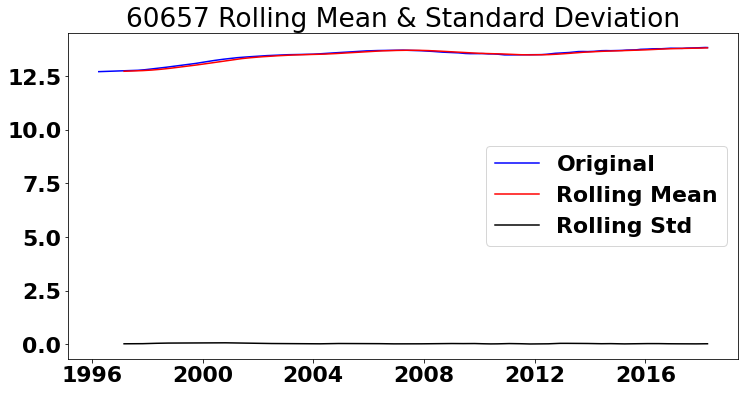

Results of Dickey-Fuller Test: 

Test Statistic                  -3.287100
p-value                          0.015465
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


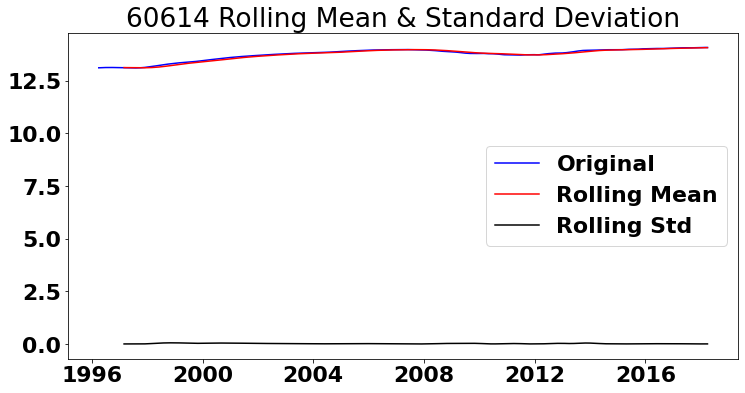

Results of Dickey-Fuller Test: 

Test Statistic                  -3.738205
p-value                          0.003607
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


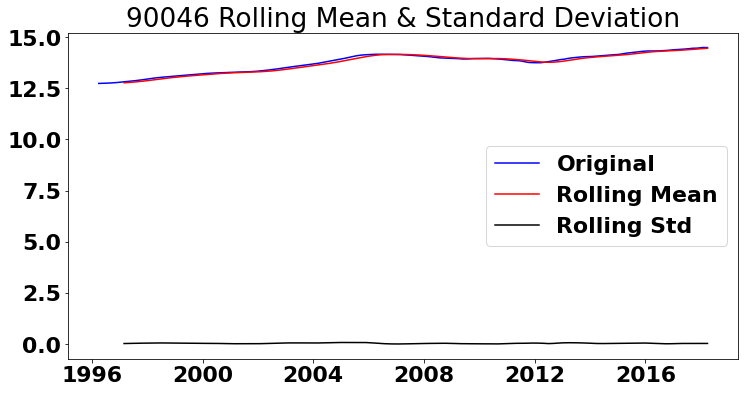

Results of Dickey-Fuller Test: 

Test Statistic                  -1.540057
p-value                          0.513611
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


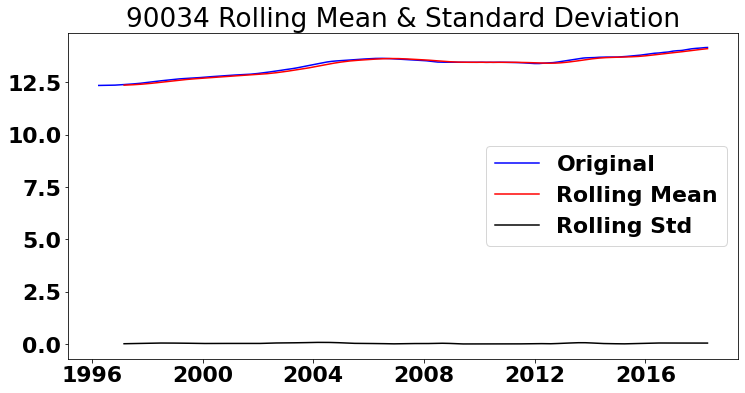

Results of Dickey-Fuller Test: 

Test Statistic                  -1.355672
p-value                          0.603334
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


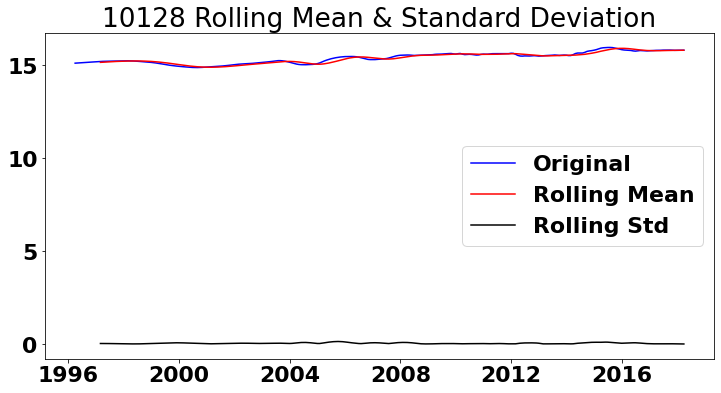

Results of Dickey-Fuller Test: 

Test Statistic                  -0.412422
p-value                          0.908004
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


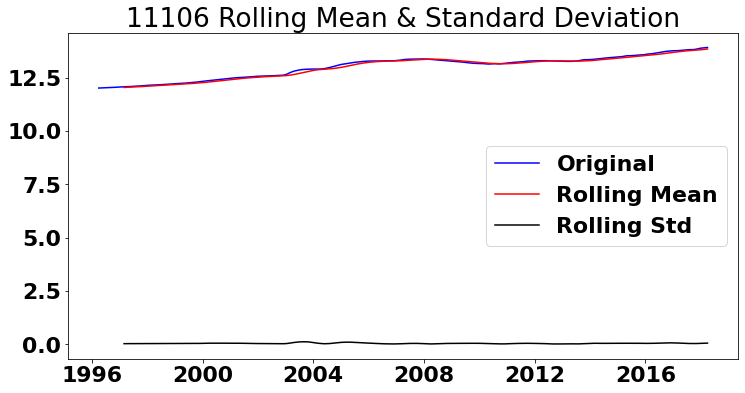

Results of Dickey-Fuller Test: 

Test Statistic                  -0.988753
p-value                          0.757344
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [29]:
for column in log.columns:
    trend(log, column)

Log transforming looks like it works for the first 2 zipcodes, but not the rest.

In [30]:
transposed_diff = transposed.diff(periods=1)
for x in range(0,1):
    transposed_diff.drop(index=transposed_diff.index[0], axis=0, inplace=True)

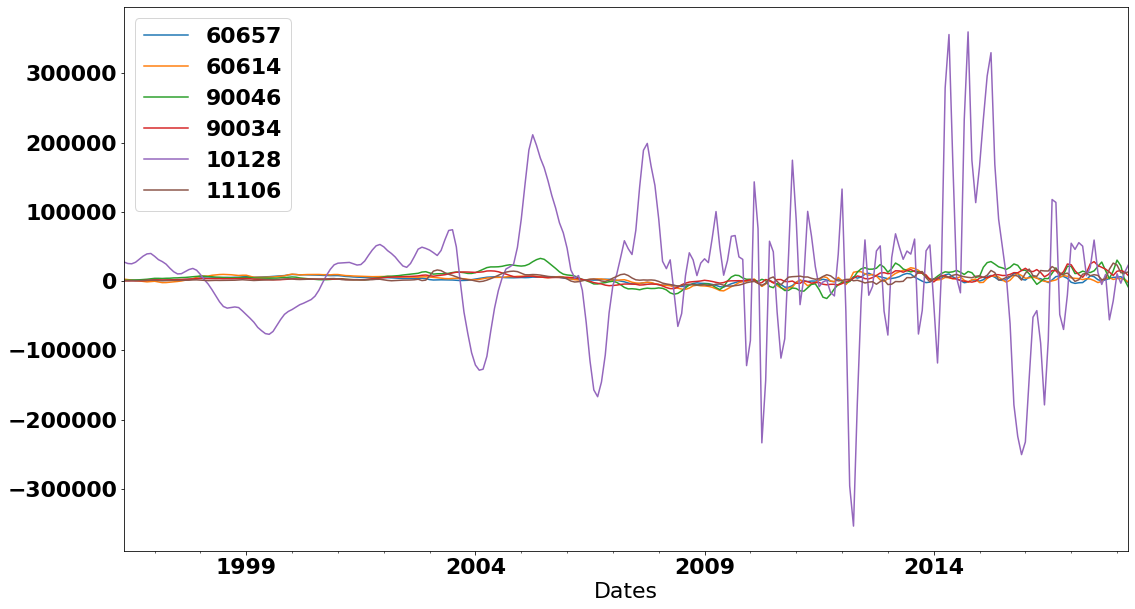

In [31]:
transposed_diff.plot(figsize = (18,10), subplots=False, legend=True)
plt.show()

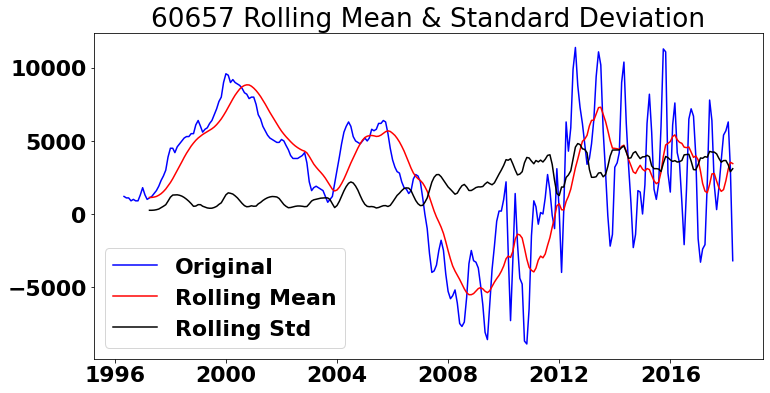

Results of Dickey-Fuller Test: 

Test Statistic                  -1.942973
p-value                          0.312123
#Lags Used                      16.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


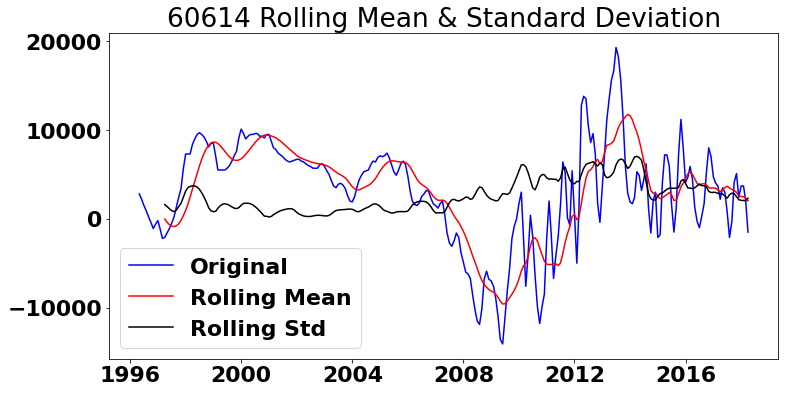

Results of Dickey-Fuller Test: 

Test Statistic                  -2.026264
p-value                          0.275177
#Lags Used                      16.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


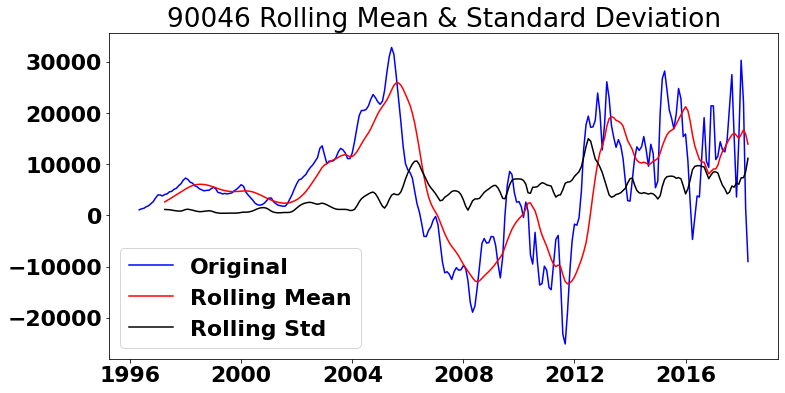

Results of Dickey-Fuller Test: 

Test Statistic                  -2.669968
p-value                          0.079381
#Lags Used                      14.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


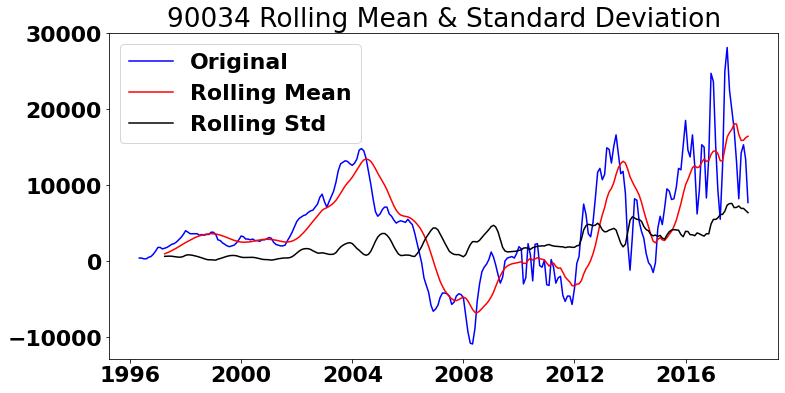

Results of Dickey-Fuller Test: 

Test Statistic                  -2.572416
p-value                          0.098833
#Lags Used                      14.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


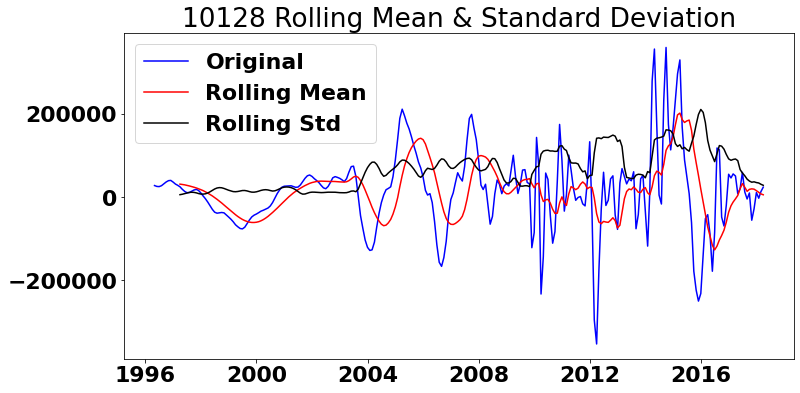

Results of Dickey-Fuller Test: 

Test Statistic                  -4.569093
p-value                          0.000147
#Lags Used                      14.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


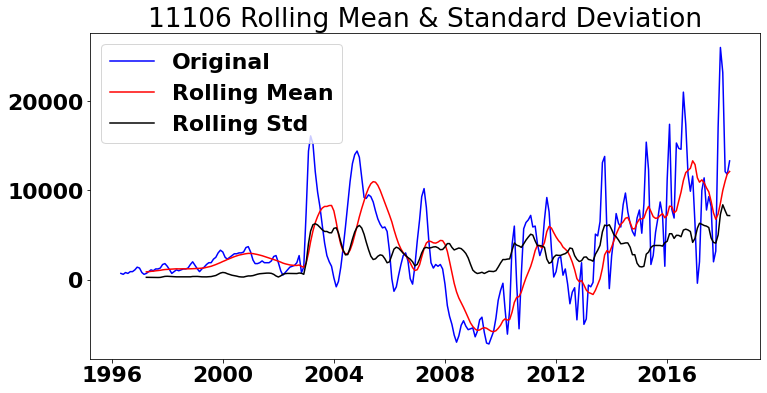

Results of Dickey-Fuller Test: 

Test Statistic                  -1.349580
p-value                          0.606196
#Lags Used                      16.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


In [32]:
for column in transposed_diff.columns:
    trend(transposed_diff, column)

Differencing with 1 period works for the 5th zipcode.

In [33]:
log_diff2 = log.diff(periods=2)
for x in range(0,2):
    log_diff2.drop(index=log_diff2.index[0], axis=0, inplace=True)

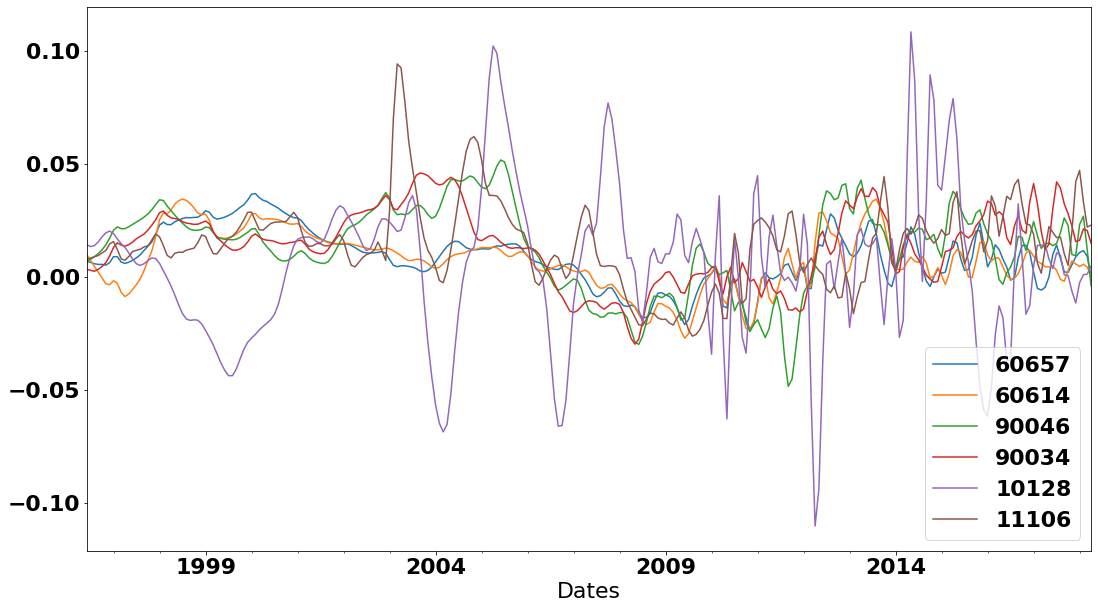

In [34]:
log_diff2.plot(figsize = (18,10), subplots=False, legend=True)
plt.show()

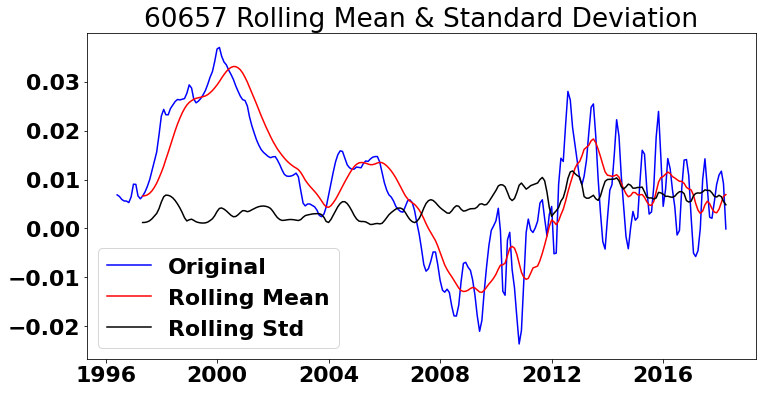

Results of Dickey-Fuller Test: 

Test Statistic                  -1.676942
p-value                          0.443030
#Lags Used                      10.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


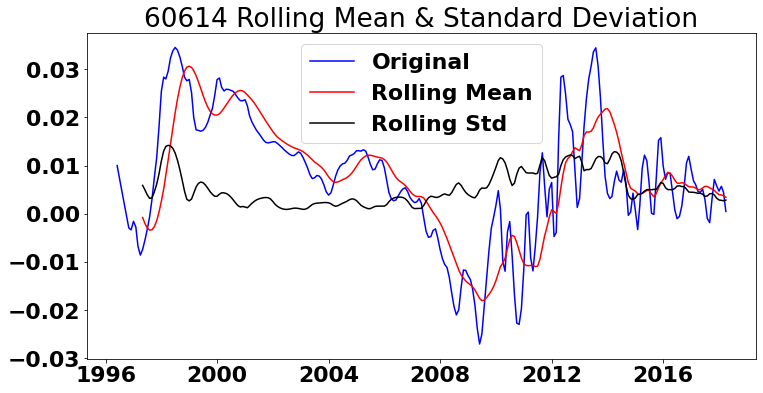

Results of Dickey-Fuller Test: 

Test Statistic                  -2.056088
p-value                          0.262534
#Lags Used                       8.000000
Number of Observations Used    254.000000
Critical Value (1%)             -3.456360
Critical Value (5%)             -2.872987
Critical Value (10%)            -2.572870
dtype: float64


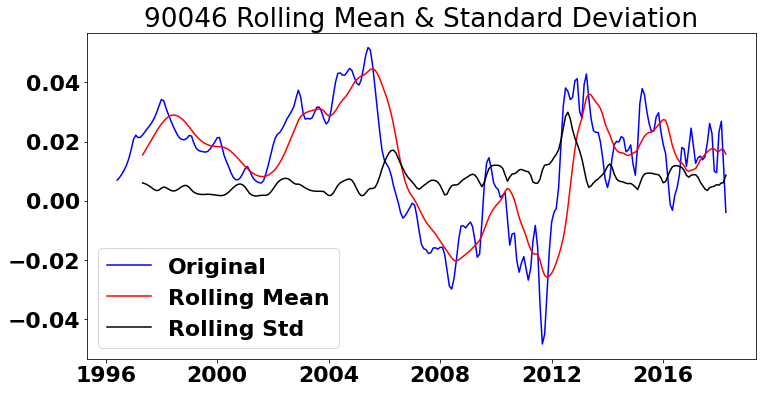

Results of Dickey-Fuller Test: 

Test Statistic                  -2.708923
p-value                          0.072507
#Lags Used                       9.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


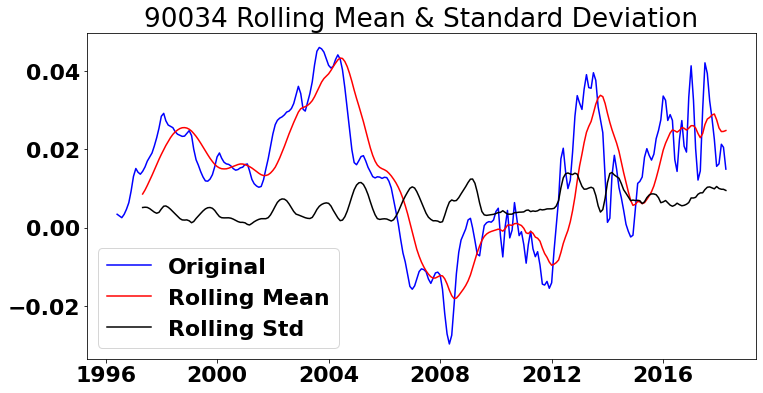

Results of Dickey-Fuller Test: 

Test Statistic                  -2.880905
p-value                          0.047614
#Lags Used                       9.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


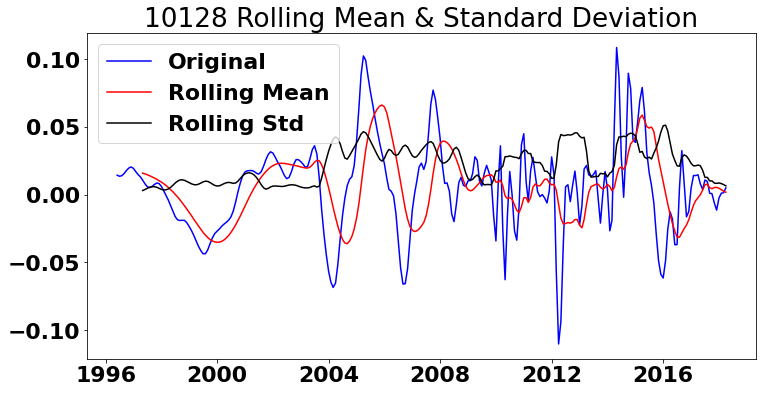

Results of Dickey-Fuller Test: 

Test Statistic                  -3.214101
p-value                          0.019183
#Lags Used                      16.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


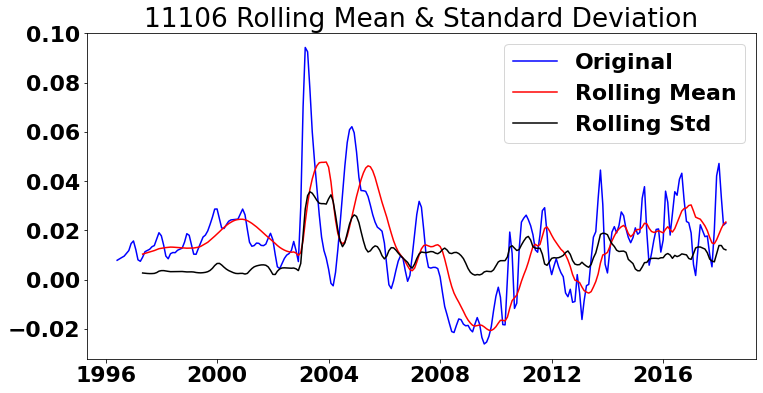

Results of Dickey-Fuller Test: 

Test Statistic                  -2.476135
p-value                          0.121389
#Lags Used                      11.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [35]:
for column in log_diff2.columns:
    trend(log_diff2, column)

Differencing with 2 periods after log transforming works for the 4th zipcode.

In [36]:
log_diff3 = log.diff(periods=3)
for x in range(0,3):
    log_diff3.drop(index=log_diff3.index[0], axis=0, inplace=True)

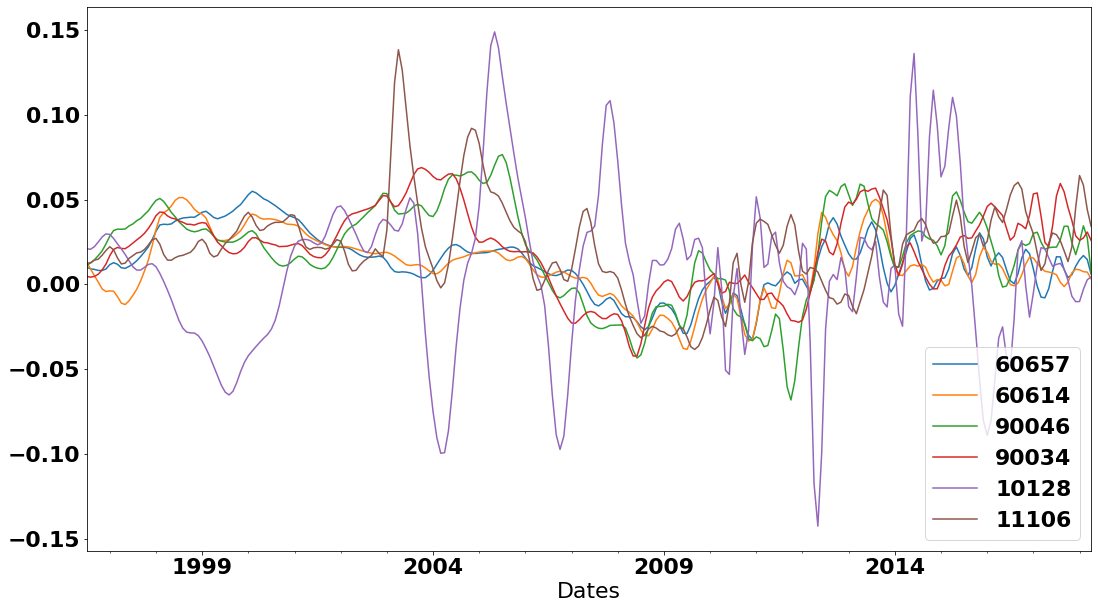

In [37]:
log_diff3.plot(figsize = (18,10), subplots=False, legend=True)
plt.show()

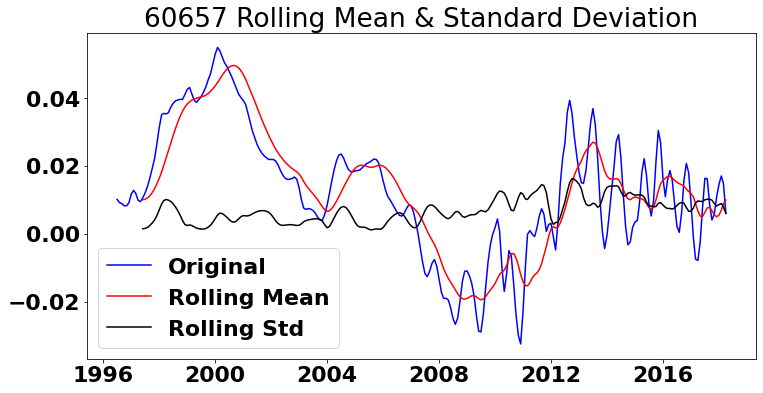

Results of Dickey-Fuller Test: 

Test Statistic                  -2.033152
p-value                          0.272229
#Lags Used                      15.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


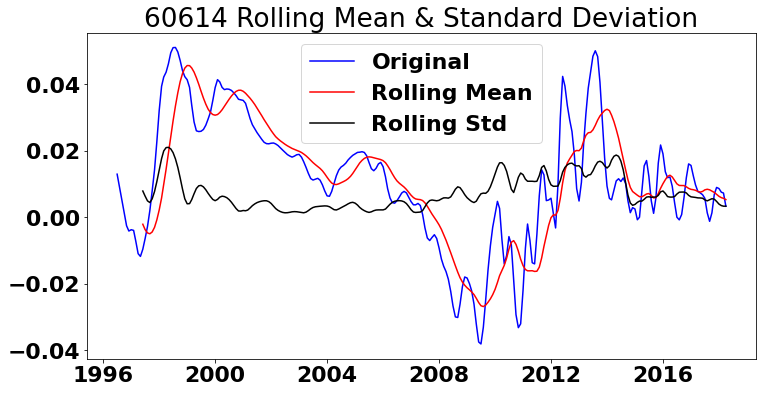

Results of Dickey-Fuller Test: 

Test Statistic                  -1.881891
p-value                          0.340627
#Lags Used                      16.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


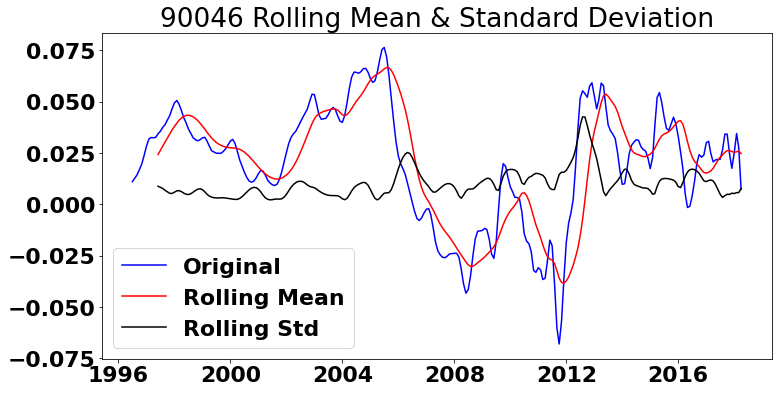

Results of Dickey-Fuller Test: 

Test Statistic                  -2.969288
p-value                          0.037864
#Lags Used                      11.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


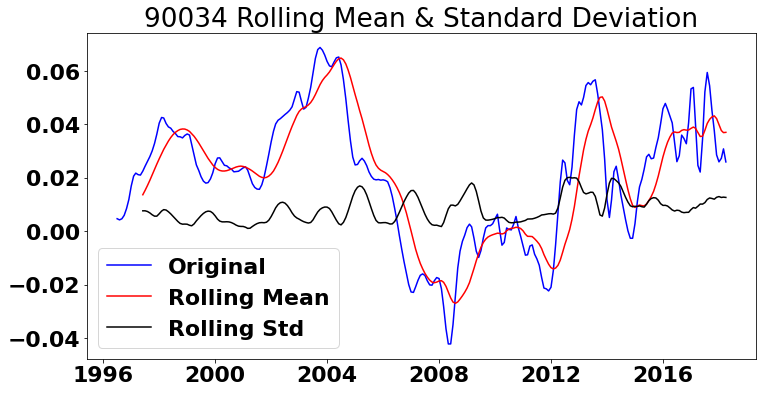

Results of Dickey-Fuller Test: 

Test Statistic                  -2.278152
p-value                          0.179111
#Lags Used                      15.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


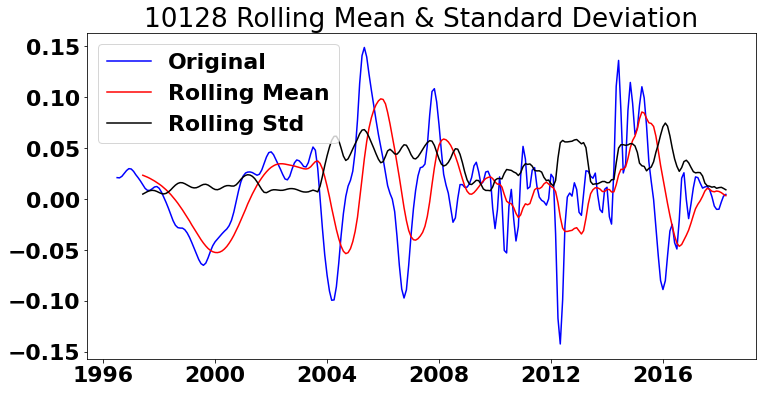

Results of Dickey-Fuller Test: 

Test Statistic                  -3.903214
p-value                          0.002011
#Lags Used                      15.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


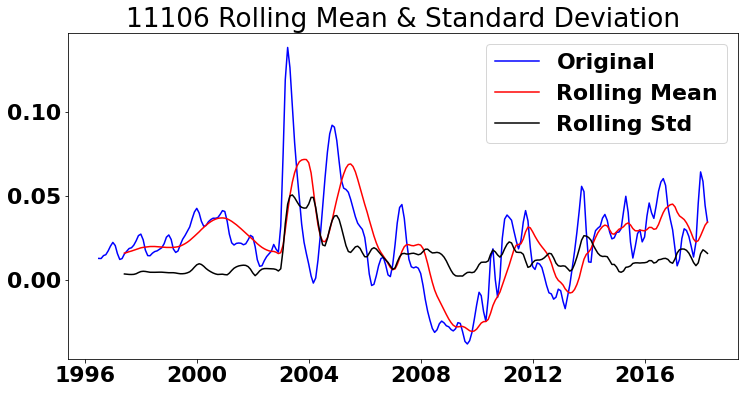

Results of Dickey-Fuller Test: 

Test Statistic                  -2.512269
p-value                          0.112518
#Lags Used                      11.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


In [38]:
for column in log_diff3.columns:
    trend(log_diff3, column)

Differencing with 3 periods after log transforming works for the 3rd and 6th zipcodes.

Breakdown the dataframe by zipcode so they can run through their own models.

In [39]:
chi1 = pd.DataFrame(log[60657])
chi2 = pd.DataFrame(log[60614])
la1 = pd.DataFrame(log_diff3[90046])
la2 = pd.DataFrame(log_diff2[90034])
ny1 = pd.DataFrame(transposed_diff[10128])
ny2 = pd.DataFrame(log_diff3[11106])

In [40]:
zips = [chi1, chi2, la1, la2, ny1, ny2]

Now we will check the ACF and PACF for each dataset so we can determine p and q values to use in our ARIMA models.

In [41]:
#function to print the acf and pacf for each zipcode 
#use to check for seasonality
def acf_pacf(data):
    rcParams['figure.figsize'] = 14, 5
    plot_acf(data, lags=50);
    plot_pacf(data, lags=50);

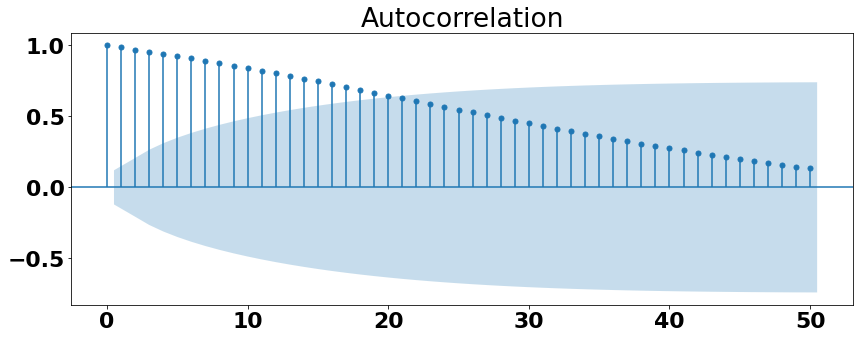

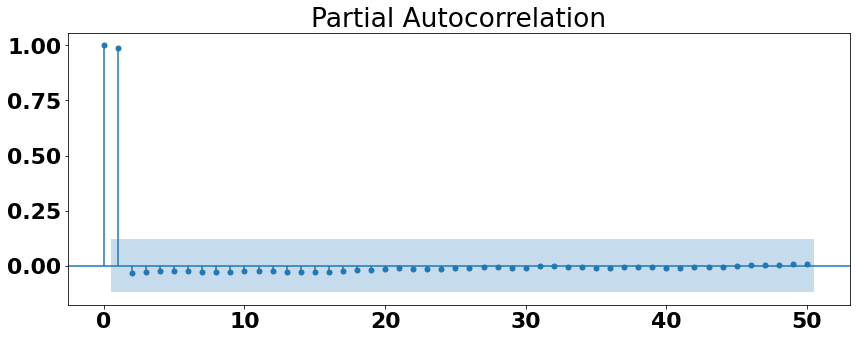

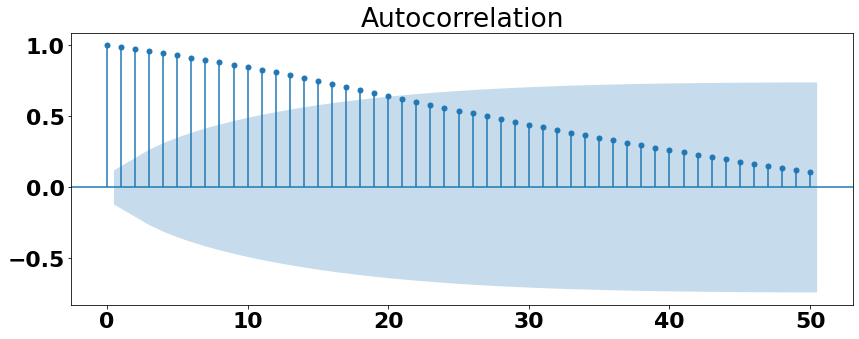

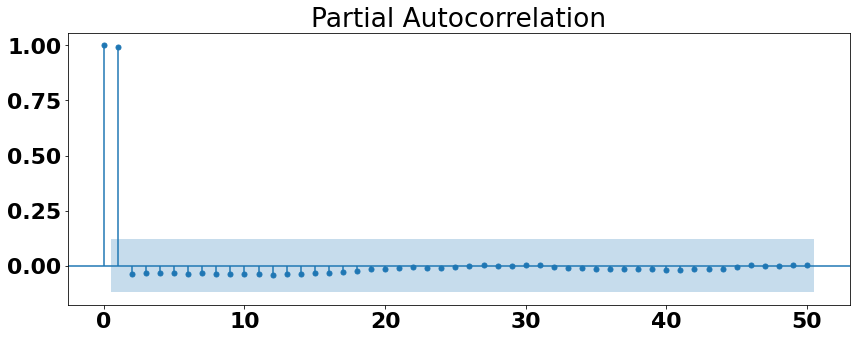

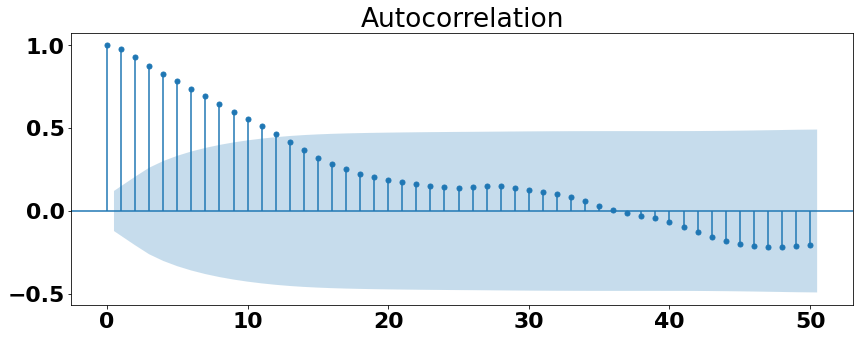

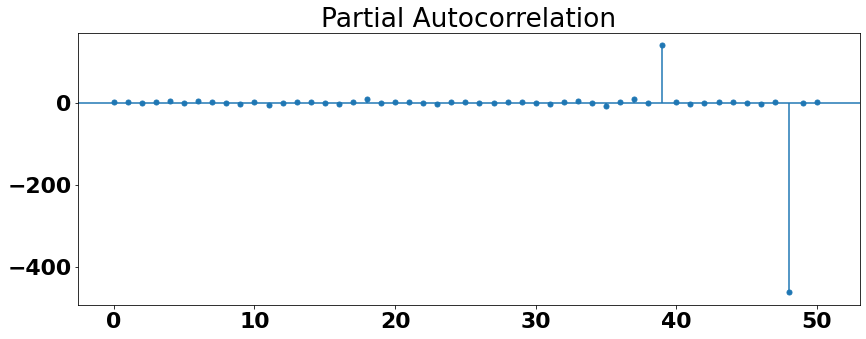

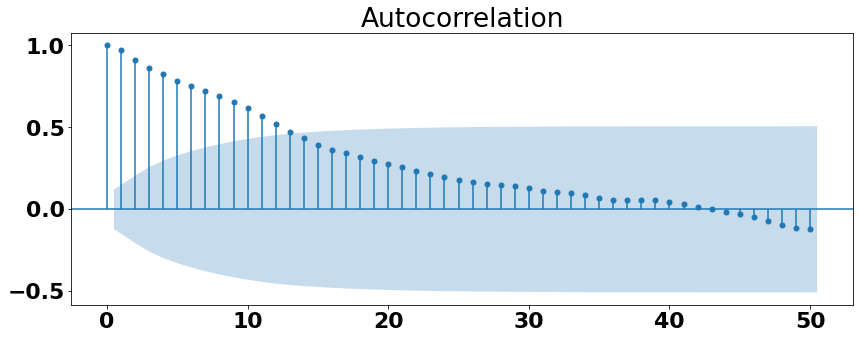

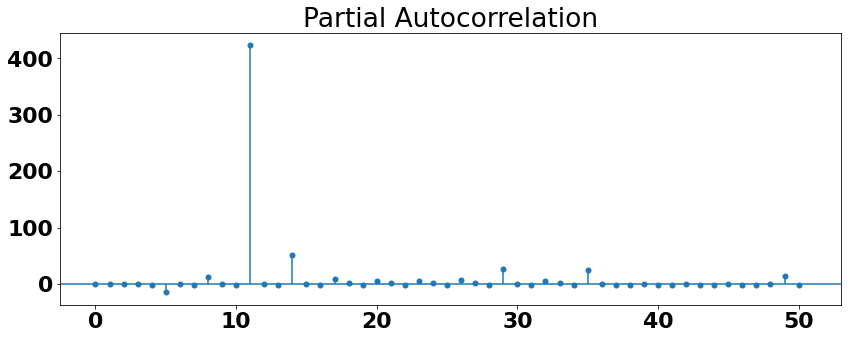

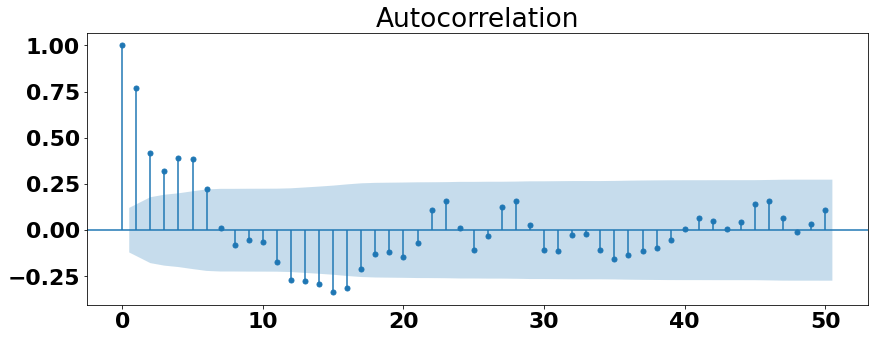

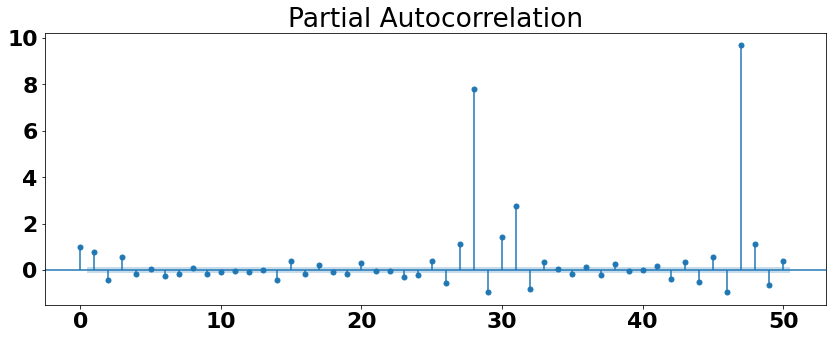

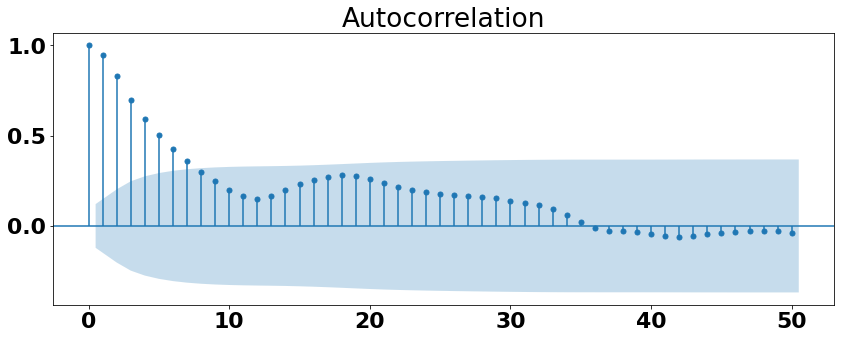

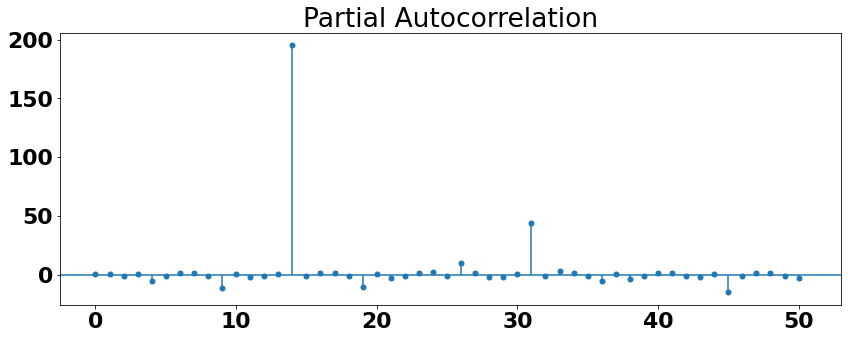

In [42]:
for x in zips:
    acf_pacf(x)

# Step 4: ARIMA Modeling

First we will start off by creating baseline models for each of the zipcodes. The parameters for these models will be determined by the ACF, PACF, and other EDA done previously.

In [43]:
chi1 = pd.DataFrame(log[60657])
chi2 = pd.DataFrame(log[60614])
#difference by 3
la1 = pd.DataFrame(log[90046])
#difference by 2
la2 = pd.DataFrame(log[90034])
#difference by 1
ny1 = pd.DataFrame(transposed[10128])
#difference by 3
ny2 = pd.DataFrame(log[11106])

In [88]:
def model(data, order, normalize=False):
    train, test = data.iloc[:199], data.iloc[199:]
    
    ar1 = ARIMA(train, order=order).fit()
    trainpreds = ar1.predict()
    testpreds = ar1.forecast(66)
    
    if normalize:
        train_norm = [math.exp(x) for x in train[data.columns[0]]]
        train_normpreds = [math.exp(x) for x in trainpreds]
        test_norm = [math.exp(x) for x in test[data.columns[0]]]
        test_normpreds = [math.exp(x) for x in testpreds]
        
        return [mean_squared_error(train_norm, train_normpreds)**0.5, mean_squared_error(test_norm, test_normpreds)**0.5]
        
    else:
        plt.plot(data, label='Actual')
        plt.plot(trainpreds.append(testpreds), label='Prediction')
        plt.legend()
        plt.show()
    
        print(ar1.summary())
        print('{} Train RMSE: '.format(data.columns[0]), mean_squared_error(train, trainpreds)**0.5)
        print('{} Test RMSE: '.format(data.columns[0]), mean_squared_error(test, testpreds)**0.5)

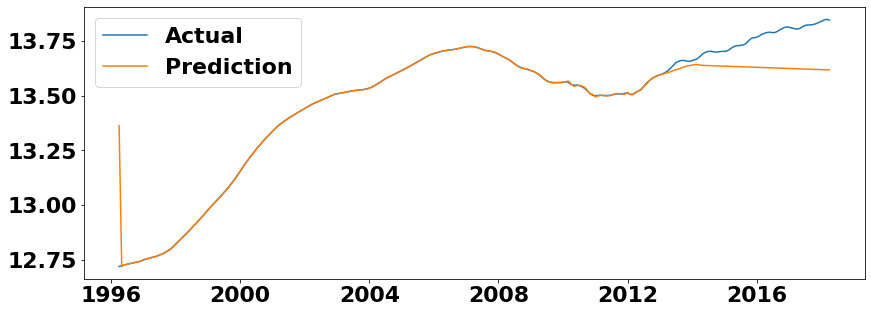

                               SARIMAX Results                                
Dep. Variable:                  60657   No. Observations:                  199
Model:                ARIMA(1, 0, 19)   Log Likelihood                1015.788
Date:                Fri, 10 Sep 2021   AIC                          -1987.576
Time:                        23:29:45   BIC                          -1915.123
Sample:                    04-01-1996   HQIC                         -1958.252
                         - 10-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.3632      0.840     15.915      0.000      11.717      15.009
ar.L1          0.9983      0.008    132.382      0.000       0.984       1.013
ma.L1          1.4456      0.062     23.330      0.0

In [52]:
model(chi1, (1,0,19))

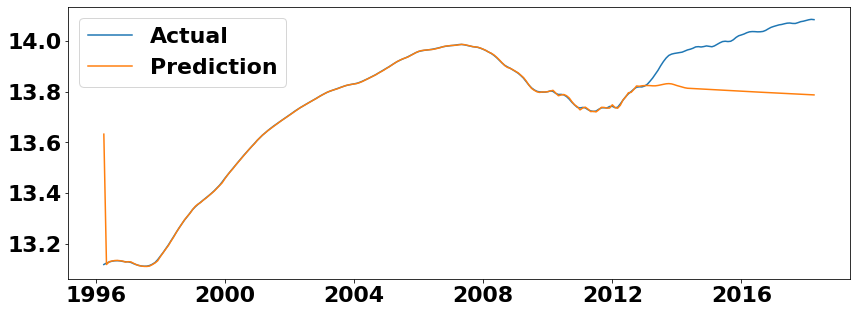

                               SARIMAX Results                                
Dep. Variable:                  60614   No. Observations:                  199
Model:                ARIMA(1, 0, 19)   Log Likelihood                 982.171
Date:                Fri, 10 Sep 2021   AIC                          -1920.341
Time:                        23:29:48   BIC                          -1847.889
Sample:                    04-01-1996   HQIC                         -1891.018
                         - 10-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.6321      0.455     29.991      0.000      12.741      14.523
ar.L1          0.9967      0.009    111.290      0.000       0.979       1.014
ma.L1          1.5332      0.089     17.150      0.0

In [53]:
model(chi2, (1,0,19))

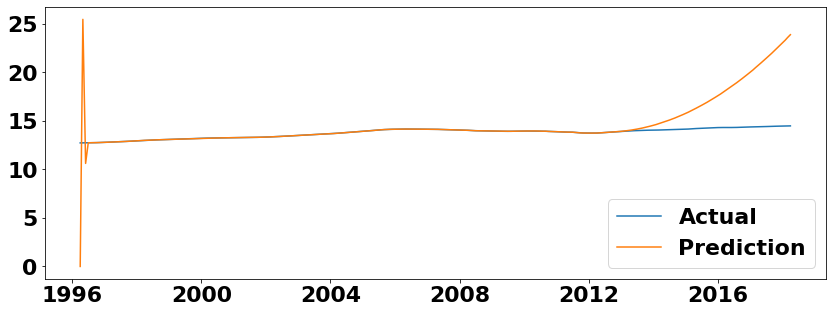

                               SARIMAX Results                                
Dep. Variable:                  90046   No. Observations:                  199
Model:                ARIMA(0, 3, 12)   Log Likelihood                 982.465
Date:                Fri, 10 Sep 2021   AIC                          -1938.929
Time:                        23:29:48   BIC                          -1896.314
Sample:                    04-01-1996   HQIC                         -1921.676
                         - 10-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0758      0.047      1.616      0.106      -0.016       0.168
ma.L2         -0.7727      0.057    -13.450      0.000      -0.885      -0.660
ma.L3         -0.4474      0.059     -7.579      0.0

In [54]:
model(la1, (0,3,12))

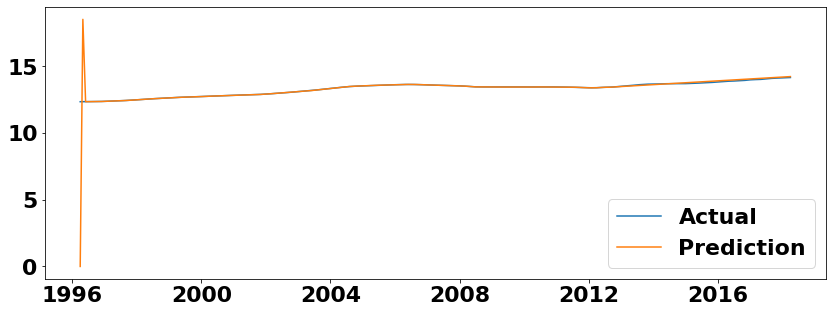

                               SARIMAX Results                                
Dep. Variable:                  90034   No. Observations:                  199
Model:                ARIMA(0, 2, 12)   Log Likelihood                 965.433
Date:                Fri, 10 Sep 2021   AIC                          -1904.865
Time:                        23:29:49   BIC                          -1862.184
Sample:                    04-01-1996   HQIC                         -1887.587
                         - 10-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1       1.035e-06      0.074   1.41e-05      1.000      -0.144       0.144
ma.L2      -6.378e-07      0.082  -7.77e-06      1.000      -0.161       0.161
ma.L3        6.64e-07      0.093   7.12e-06      1.0

In [55]:
model(la2, (0,2,12))

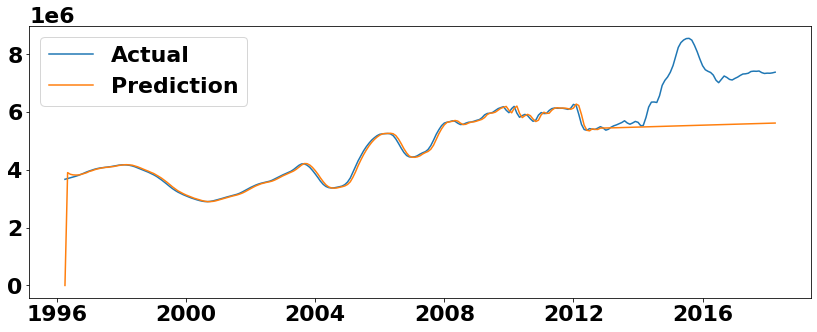

                               SARIMAX Results                                
Dep. Variable:                  10128   No. Observations:                  199
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -2667.616
Date:                Fri, 10 Sep 2021   AIC                           5357.233
Time:                        23:29:50   BIC                           5393.404
Sample:                    04-01-1996   HQIC                          5371.874
                         - 10-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6615      0.270     -2.446      0.014      -1.192      -0.131
ar.L2          1.0205      0.152      6.709      0.000       0.722       1.319
ar.L3          1.3535      0.247      5.484      0.0

In [56]:
model(ny1, (5,1,5))

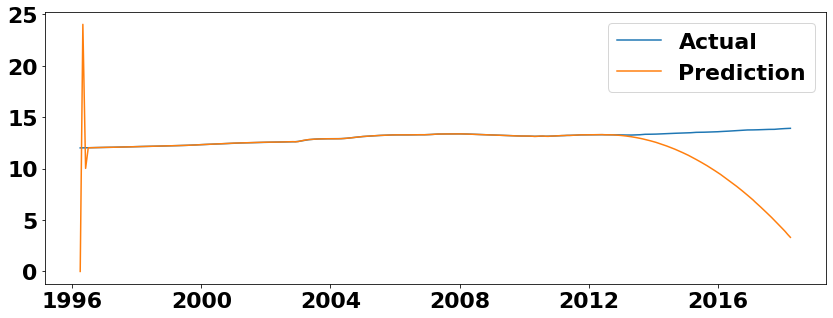

                               SARIMAX Results                                
Dep. Variable:                  11106   No. Observations:                  199
Model:                 ARIMA(2, 3, 7)   Log Likelihood                 863.196
Date:                Fri, 10 Sep 2021   AIC                          -1706.393
Time:                        23:29:50   BIC                          -1673.612
Sample:                    04-01-1996   HQIC                         -1693.121
                         - 10-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3502      0.395      0.886      0.375      -0.424       1.125
ar.L2         -0.5778      0.428     -1.351      0.177      -1.416       0.261
ma.L1      -3.026e-06      0.414  -7.31e-06      1.0

In [57]:
model(ny2, (2,3,7))

# Step 5: AutoARIMA

Now that we have our baseline models, we will use auto ARIMA to find the optimal parameters for each zipcode's model. 

In [58]:
def auto(data, start_p, d, start_q, max_p, max_d, max_q):
    train, test = data.iloc[:199], data.iloc[199:]
    
    arima_model = auto_arima(train, start_p=start_p, d=d, start_q=start_q, max_p=max_p, max_d=max_d, max_q=max_q, trace=True)
    
    print(arima_model.summary())

In [59]:
auto(chi1, 0, 1, 18, 2, 3, 20)

Performing stepwise search to minimize aic
 ARIMA(0,1,18)(0,0,0)[0] intercept   : AIC=-1902.218, Time=2.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1403.772, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1928.679, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1646.049, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1340.249, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1940.340, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1923.618, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1975.320, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1979.187, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1737.410, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1940.298, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1990.055, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1869.183, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2015.879, Time=0.40 sec
 ARIMA(2,1,4)(0,0,

In [60]:
auto(chi2, 0, 1, 18, 2, 3, 20)

Performing stepwise search to minimize aic
 ARIMA(0,1,18)(0,0,0)[0] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1398.817, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1875.496, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1356.057, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1903.223, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1934.411, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1945.019, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1929.470, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1837.421, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1927.839, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1944.596, Time=0.15 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 4.552 seconds
                               SARIMAX Results                                
Dep. Var

In [61]:
auto(la1, 0, 1, 10, 2, 4, 14)

Performing stepwise search to minimize aic
 ARIMA(0,1,10)(0,0,0)[0] intercept   : AIC=-1909.936, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1239.544, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1827.944, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1489.163, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1190.815, Time=0.01 sec
 ARIMA(0,1,9)(0,0,0)[0] intercept   : AIC=-1931.891, Time=0.73 sec
 ARIMA(0,1,8)(0,0,0)[0] intercept   : AIC=-1936.903, Time=0.83 sec
 ARIMA(0,1,7)(0,0,0)[0] intercept   : AIC=-1896.154, Time=0.71 sec
 ARIMA(1,1,8)(0,0,0)[0] intercept   : AIC=-1980.048, Time=0.36 sec
 ARIMA(1,1,7)(0,0,0)[0] intercept   : AIC=-1978.771, Time=0.42 sec
 ARIMA(2,1,8)(0,0,0)[0] intercept   : AIC=-1979.568, Time=0.51 sec
 ARIMA(1,1,9)(0,0,0)[0] intercept   : AIC=-1979.043, Time=0.88 sec
 ARIMA(2,1,7)(0,0,0)[0] intercept   : AIC=-1978.045, Time=0.73 sec
 ARIMA(2,1,9)(0,0,0)[0] intercept   : AIC=-1974.746, Time=0.65 sec
 ARIMA(1,1,8)(0,0,

In [62]:
auto(la2, 0, 1, 10, 2, 4, 14)

Performing stepwise search to minimize aic
 ARIMA(0,1,10)(0,0,0)[0] intercept   : AIC=-1927.022, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1329.512, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1934.482, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1577.719, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1258.592, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1952.755, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1965.500, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1973.123, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1986.973, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1723.245, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1859.018, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1996.853, Time=0.37 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1843.620, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1999.616, Time=0.30 sec
 ARIMA(2,1,4)(0,0,

In [63]:
auto(ny1, 4, 0, 4, 6, 2, 6)

Performing stepwise search to minimize aic
 ARIMA(4,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6086.331, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5944.978, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6672.842, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4883.284, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4809.436, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4887.963, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4809.153, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4857.232, Time=0.08 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=4774.160, Time=0.12 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4786.471, Time=0.12 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=4785.576, Time=0.42 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=4803.9

In [64]:
auto(ny2, 1, 1, 5, 3, 4, 8)

Performing stepwise search to minimize aic
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=-1798.360, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1253.999, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1637.848, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1489.155, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1189.103, Time=0.01 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-1776.261, Time=0.39 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-1792.136, Time=0.20 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=-1734.525, Time=0.32 sec
 ARIMA(1,1,6)(0,0,0)[0] intercept   : AIC=-1797.391, Time=0.50 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-1773.372, Time=0.32 sec
 ARIMA(0,1,6)(0,0,0)[0] intercept   : AIC=-1778.984, Time=0.43 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-1792.146, Time=0.15 sec
 ARIMA(2,1,6)(0,0,0)[0] intercept   : AIC=-1795.920, Time=0.35 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=-1797.439, Time=0.28 sec

Best model:  ARIMA

## Dynamic:
Using the optimal parameters we just found, we will test if using SARIMAX with dynamic predictions gives better results.

In [65]:
def dynamic(data, order):
    train, test = data.iloc[:199], data.iloc[199:]
    
    model = sm.tsa.statespace.SARIMAX(train, order=order, enforce_stationarity=False, enforce_invertibility=False).fit()
    
    trainpreds = model.predict()
    preds = model.get_prediction(start=pd.to_datetime(test.index[0]), end=pd.to_datetime(test.index[len(test)-1]), dynamic=True)
    testpreds = preds.predicted_mean
    
    plt.plot(data, label='Actual')
    plt.plot(trainpreds.append(testpreds), label='Prediction')
    plt.legend()
    plt.show()
    
    print(model.summary())
    print('{} Train RMSE: '.format(data.columns[0]), mean_squared_error(train, trainpreds)**0.5)
    print('{} Test RMSE: '.format(data.columns[0]), mean_squared_error(test, testpreds)**0.5)

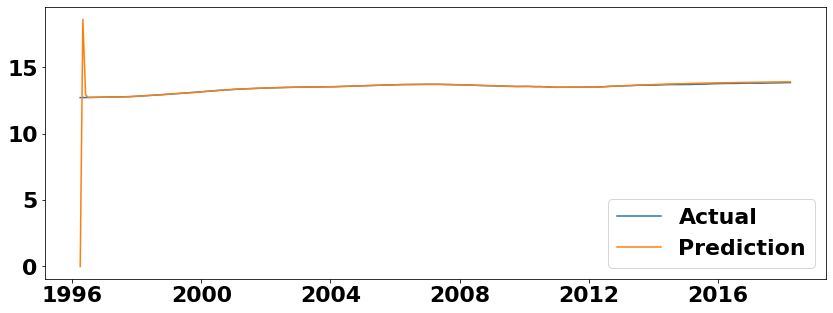

                               SARIMAX Results                                
Dep. Variable:                  60657   No. Observations:                  199
Model:               SARIMAX(2, 1, 4)   Log Likelihood                 985.939
Date:                Fri, 10 Sep 2021   AIC                          -1957.878
Time:                        23:30:31   BIC                          -1935.039
Sample:                    04-01-1996   HQIC                         -1948.629
                         - 10-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9271      0.292      3.176      0.001       0.355       1.499
ar.L2          0.0476      0.301      0.158      0.874      -0.543       0.638
ma.L1          0.6094      0.281      2.167      0.0

In [66]:
dynamic(chi1, (2,1,4))

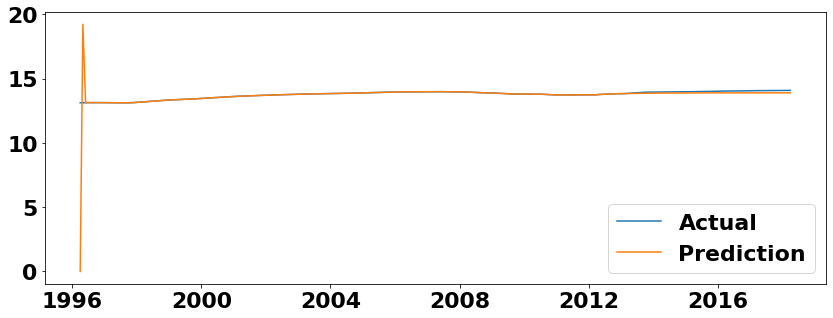

                               SARIMAX Results                                
Dep. Variable:                  60614   No. Observations:                  199
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 966.402
Date:                Fri, 10 Sep 2021   AIC                          -1926.804
Time:                        23:30:31   BIC                          -1916.970
Sample:                    04-01-1996   HQIC                         -1922.823
                         - 10-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9302      0.032     29.065      0.000       0.868       0.993
ma.L1          0.5664      0.045     12.659      0.000       0.479       0.654
sigma2      3.051e-06   1.72e-07     17.706      0.0

In [67]:
dynamic(chi2, (1,1,1))

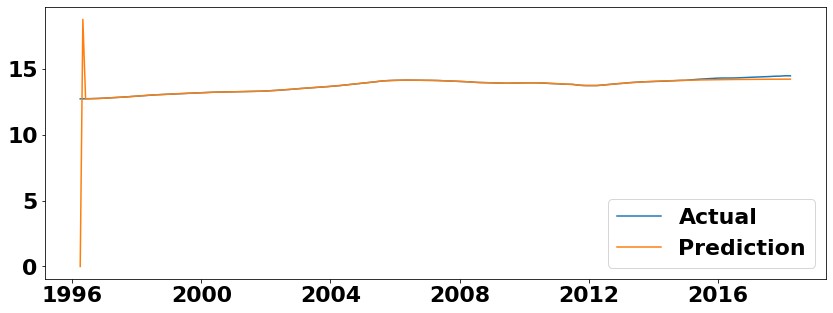

                               SARIMAX Results                                
Dep. Variable:                  90046   No. Observations:                  199
Model:               SARIMAX(1, 1, 8)   Log Likelihood                 953.530
Date:                Fri, 10 Sep 2021   AIC                          -1887.059
Time:                        23:30:32   BIC                          -1854.642
Sample:                    04-01-1996   HQIC                         -1873.926
                         - 10-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9495      0.037     25.577      0.000       0.877       1.022
ma.L1          1.1061      0.059     18.854      0.000       0.991       1.221
ma.L2          0.3217      0.100      3.202      0.0

In [68]:
dynamic(la1, (1,1,8))

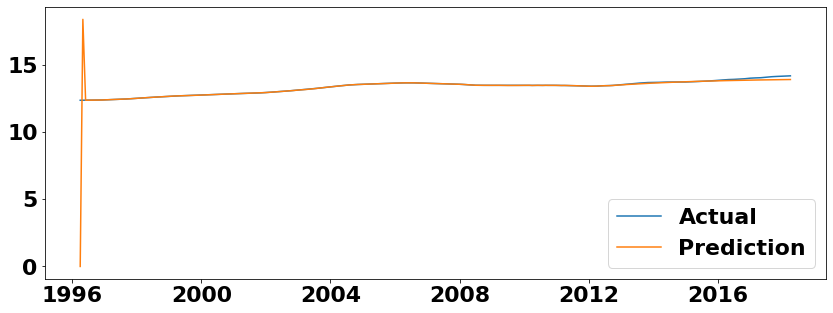

                               SARIMAX Results                                
Dep. Variable:                  90034   No. Observations:                  199
Model:               SARIMAX(1, 1, 7)   Log Likelihood                 972.789
Date:                Fri, 10 Sep 2021   AIC                          -1927.579
Time:                        23:30:32   BIC                          -1898.356
Sample:                    04-01-1996   HQIC                         -1915.741
                         - 10-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9735      0.030     32.415      0.000       0.915       1.032
ma.L1          0.6752      0.055     12.364      0.000       0.568       0.782
ma.L2         -0.0512      0.084     -0.607      0.5

In [69]:
dynamic(la2, (1,1,7))

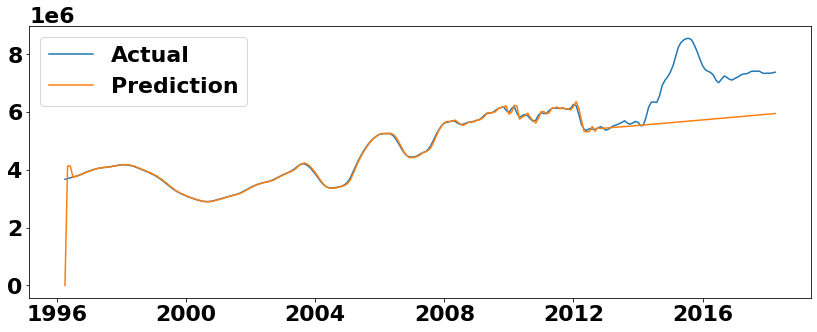

                               SARIMAX Results                                
Dep. Variable:                  10128   No. Observations:                  199
Model:               SARIMAX(4, 0, 1)   Log Likelihood               -2359.917
Date:                Fri, 10 Sep 2021   AIC                           4731.834
Time:                        23:30:33   BIC                           4751.472
Sample:                    04-01-1996   HQIC                          4739.785
                         - 10-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1259      0.030     37.988      0.000       1.068       1.184
ar.L2          0.1199      0.031      3.809      0.000       0.058       0.182
ar.L3         -0.1230      0.034     -3.606      0.0

In [70]:
dynamic(ny1, (4,0,1))

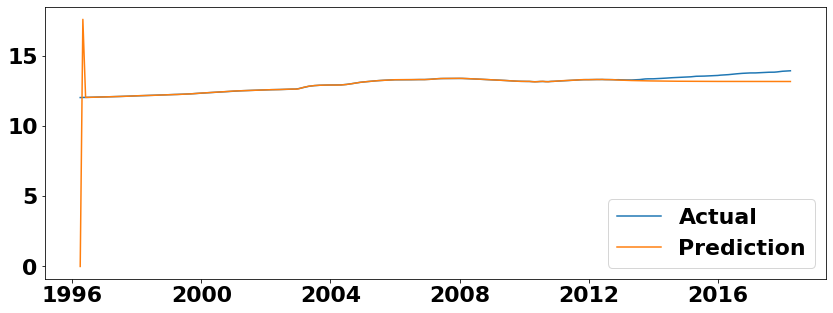

                               SARIMAX Results                                
Dep. Variable:                  11106   No. Observations:                  199
Model:               SARIMAX(1, 1, 5)   Log Likelihood                 875.628
Date:                Fri, 10 Sep 2021   AIC                          -1737.256
Time:                        23:30:33   BIC                          -1714.454
Sample:                    04-01-1996   HQIC                         -1728.021
                         - 10-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9260      0.057     16.334      0.000       0.815       1.037
ma.L1          1.0806      0.068     15.945      0.000       0.948       1.213
ma.L2          0.1883      0.138      1.365      0.1

In [71]:
dynamic(ny2, (1,1,5))

# Step 6: Predict

Now that we know the optimal parameters for each zipcode's model, we will try to forecast prices in the future.

In [72]:
def predict(data, order, years, log=False, dynamic=False):
    if dynamic:
        ar1 = sm.tsa.statespace.SARIMAX(data, order=order, enforce_stationarity=False, enforce_invertibility=False).fit()
    
        preds = ar1.get_prediction(start=pd.to_datetime(data.index[len(data)-1]), 
                                     end=pd.to_datetime('{}-04'.format(2018+years), format='%Y-%m'), dynamic=True)
        testpreds = preds.predicted_mean
    else:
        ar1 = ARIMA(data, order=order).fit()
        testpreds = ar1.forecast(years*12)
    
    if log:
        original_log = data[data.columns[0]][len(data)-1]
        original_price = math.exp(original_log)
        final_log = testpreds[years*12-1]
        final_price = math.exp(final_log)
    else:
        original_price = data[data.columns[0]][len(data)-1]
        final_price = testpreds[years*12-1]
    
    roi = ((final_price - original_price)/original_price)*100
    

 
    plt.plot(data, label='Actual')
    plt.plot(testpreds, label='Prediction')
    plt.title('Prediction for {} in {} Years'.format(data.columns[0], years))
    plt.legend()
    plt.show()
    
    print(ar1.summary())
    print('Price Today: ${}'.format(original_price))
    print('Price in {} years: ${}'.format(years, final_price))
    print('ROI: {}%'.format(roi))

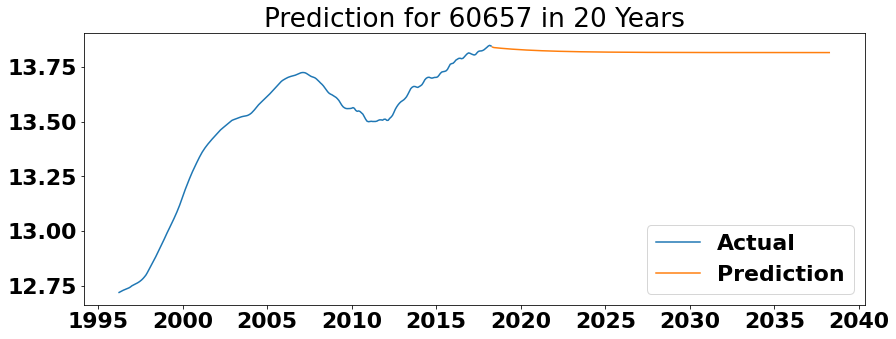

                               SARIMAX Results                                
Dep. Variable:                  60657   No. Observations:                  265
Model:                 ARIMA(2, 1, 4)   Log Likelihood                1310.907
Date:                Fri, 10 Sep 2021   AIC                          -2607.815
Time:                        23:30:33   BIC                          -2582.783
Sample:                    04-01-1996   HQIC                         -2597.756
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2706      0.025     51.602      0.000       1.222       1.319
ar.L2         -0.2908      0.026    -11.271      0.000      -0.341      -0.240
ma.L1          0.3724      0.029     12.905      0.0

In [73]:
predict(chi1, (2,1,4), 20, log=True)

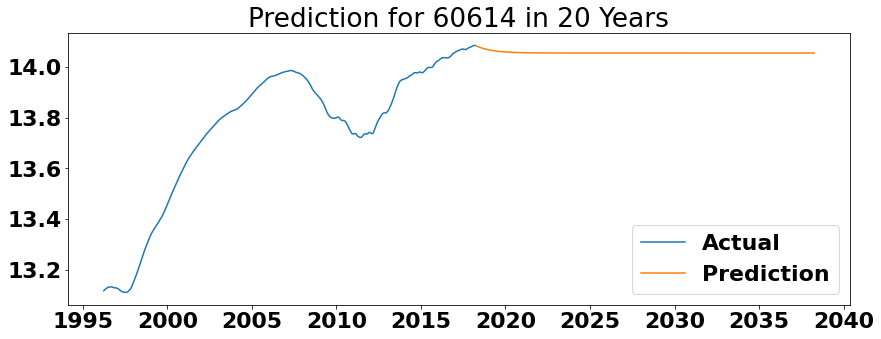

                               SARIMAX Results                                
Dep. Variable:                  60614   No. Observations:                  265
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1297.997
Date:                Fri, 10 Sep 2021   AIC                          -2589.995
Time:                        23:30:34   BIC                          -2579.267
Sample:                    04-01-1996   HQIC                         -2585.684
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9120      0.027     34.345      0.000       0.860       0.964
ma.L1          0.6233      0.039     16.120      0.000       0.547       0.699
sigma2      3.087e-06   1.62e-07     19.029      0.0

In [74]:
predict(chi2, (1,1,1), 20, log=True)

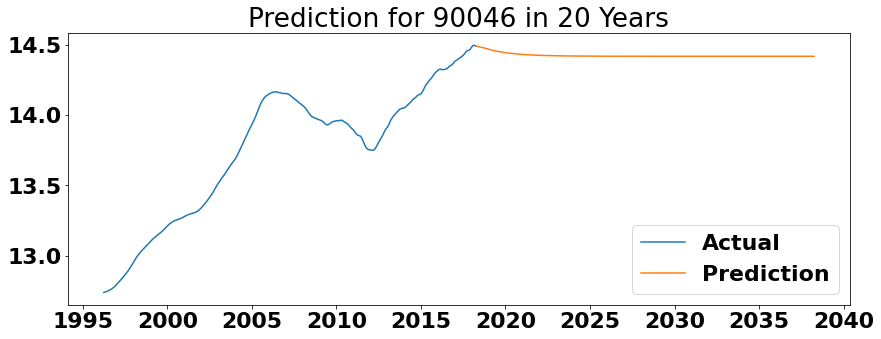

                               SARIMAX Results                                
Dep. Variable:                  90046   No. Observations:                  265
Model:                 ARIMA(1, 1, 8)   Log Likelihood                1268.193
Date:                Fri, 10 Sep 2021   AIC                          -2516.385
Time:                        23:30:35   BIC                          -2480.626
Sample:                    04-01-1996   HQIC                         -2502.016
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9464      0.028     33.925      0.000       0.892       1.001
ma.L1          0.9470      0.062     15.289      0.000       0.826       1.068
ma.L2         -0.0488      0.084     -0.583      0.5

In [75]:
predict(la1, (1,1,8), 20, log=True)

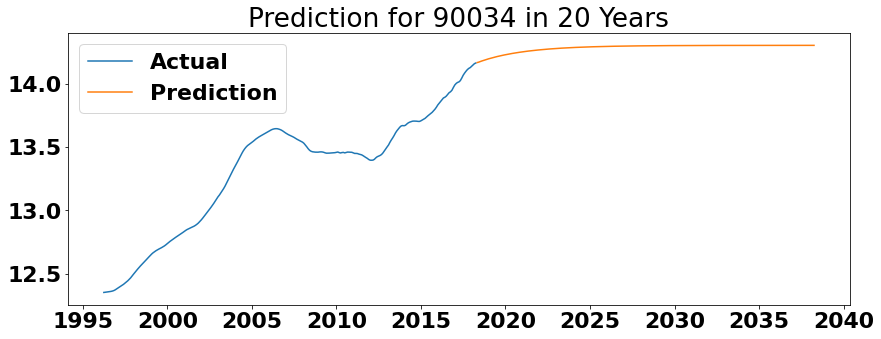

                               SARIMAX Results                                
Dep. Variable:                  90034   No. Observations:                  265
Model:                 ARIMA(1, 1, 7)   Log Likelihood                1289.653
Date:                Fri, 10 Sep 2021   AIC                          -2561.307
Time:                        23:30:35   BIC                          -2529.123
Sample:                    04-01-1996   HQIC                         -2548.374
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9702      0.018     53.859      0.000       0.935       1.005
ma.L1          0.7442      0.048     15.666      0.000       0.651       0.837
ma.L2         -0.2260      0.066     -3.445      0.0

In [76]:
predict(la2, (1,1,7), 20, log=True)

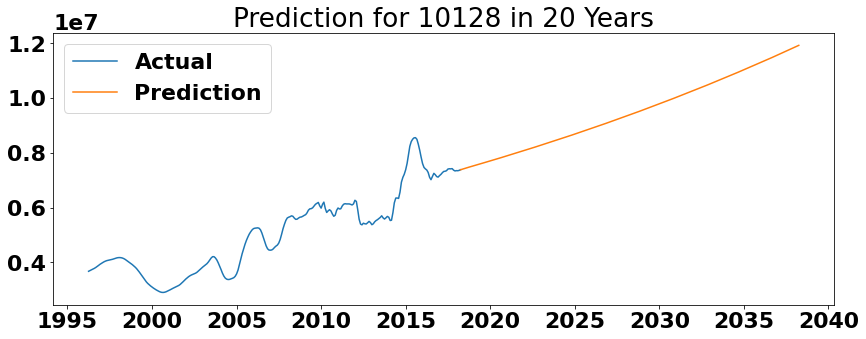

                               SARIMAX Results                                
Dep. Variable:                  10128   No. Observations:                  265
Model:               SARIMAX(4, 0, 1)   Log Likelihood               -3201.081
Date:                Fri, 10 Sep 2021   AIC                           6414.162
Time:                        23:30:36   BIC                           6435.550
Sample:                    04-01-1996   HQIC                          6422.759
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2260      0.030     40.774      0.000       1.167       1.285
ar.L2          0.0179      0.034      0.535      0.593      -0.048       0.084
ar.L3         -0.2461      0.036     -6.902      0.0

In [77]:
predict(ny1, (4,0,1), 20, dynamic=True)

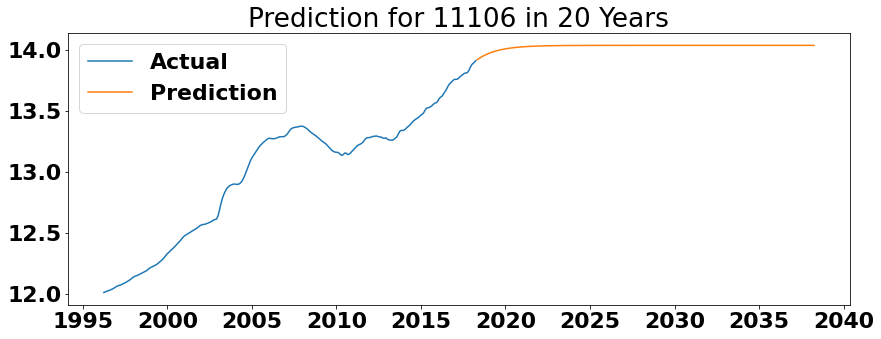

                               SARIMAX Results                                
Dep. Variable:                  11106   No. Observations:                  265
Model:                 ARIMA(1, 1, 5)   Log Likelihood                1141.088
Date:                Fri, 10 Sep 2021   AIC                          -2268.176
Time:                        23:30:36   BIC                          -2243.144
Sample:                    04-01-1996   HQIC                         -2258.117
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9317      0.041     22.684      0.000       0.851       1.012
ma.L1          0.8376      0.061     13.651      0.000       0.717       0.958
ma.L2         -0.2092      0.095     -2.212      0.0

In [78]:
predict(ny2, (1,1,5), 20, log=True)

 ### Invest in:
 It looks like zipcode 10128 did the best, with a projected 61% ROI over 20 years. Second best was 90034 at 15% ROI.
 
 ### Avoid:
 Zipcodes 90046, 60657, and 60614 had negative projected ROI at -7%, -2.9%, and -2.8% respectively

In [106]:
zips2 = [chi1, chi2, la1, la2, ny2]
orders = [(2,1,4), (1,1,1), (1,1,8), (1,1,7), (1,1,5)]
rmse = pd.DataFrame()

In [107]:
training = []
testing = []
for i, x in enumerate(zips2):
    train_rmse = model(x, orders[i], normalize=True)[0]
    test_rmse = model(x, orders[i], normalize=True)[1]
    
    training.append(train_rmse)
    testing.append(test_rmse)
training.append(267597)
testing.append(1486386)

In [108]:
rmse['Train RMSE'] = training
rmse['Test RMSE'] = testing

In [109]:
rmse

,Train RMSE,Test RMSE
0,23714.708926,5.695675e+04
1,35345.599589,1.449125e+05
2,24197.375855,2.014752e+05
3,16422.916280,1.343281e+05
4,11717.490288,2.985230e+05
5,267597.000000,1.486386e+06


In [110]:
rmse.set_index(pd.Index([60657, 60614, 90046, 90034, 10128, 11106]), inplace=True)

In [111]:
rmse.rename_axis('Zip Code', inplace=True)

In [112]:
rmse

,Train RMSE,Test RMSE
Zip Code,,
60657,23714.708926,5.695675e+04
60614,35345.599589,1.449125e+05
90046,24197.375855,2.014752e+05
90034,16422.916280,1.343281e+05
10128,11717.490288,2.985230e+05
11106,267597.000000,1.486386e+06


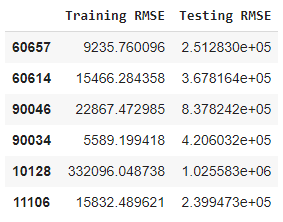